In [1]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP 
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

# Config

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [3]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [4]:
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
sigmas = torch.tensor(np.array(np_sigmas)).float().to(device).view(-1, 1)

In [ ]:
# sample_test = np.expand_dims(toy_data.inf_train_gen('pinwheel', n_points=4096), 0)

In [ ]:
# sampled_perturbed = sample_test + np.random.randn(*sample_test.shape) * np_sigmas[..., None, None]

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# idx = 1
# plt.scatter(sampled_perturbed[idx, :, 0], sampled_perturbed[idx, :, 1])

# Training

In [5]:
score_net = SmallMLP(in_dim=2)
critic_net = SmallMLP(in_dim=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 15000
itr = 0

losses = []
sigmas = sigmas[1:]
for epoch in range(epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    tr_pts = sample_data('pinwheel', 2048).view(-1, 2)
    tr_pts.requires_grad_()
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    
    losses.append(loss)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    
    cycle_iter = itr % (k_iters + e_iters)
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

Epoch 0 (critic), Loss=0.03229 t1=-0.00439 t2=0.03668
Epoch 1 (critic), Loss=0.24346 t1=-0.02544 t2=0.26891
Epoch 2 (critic), Loss=0.42288 t1=-0.04233 t2=0.46521
Epoch 3 (critic), Loss=0.52547 t1=-0.05202 t2=0.57749
Epoch 4 (critic), Loss=0.54674 t1=-0.05330 t2=0.60004
Epoch 5 (score), Loss=0.51156 t1=-0.04735 t2=0.55891
Epoch 6 (critic), Loss=0.35480 t1=-0.20401 t2=0.55880
Epoch 7 (critic), Loss=0.29489 t1=-0.17863 t2=0.47352
Epoch 8 (critic), Loss=0.23443 t1=-0.13378 t2=0.36820
Epoch 9 (critic), Loss=0.17616 t1=-0.09296 t2=0.26913
Epoch 10 (critic), Loss=0.12973 t1=-0.06247 t2=0.19220
Epoch 11 (score), Loss=0.10245 t1=-0.03921 t2=0.14166
Epoch 12 (critic), Loss=0.07263 t1=-0.07003 t2=0.14266
Epoch 13 (critic), Loss=0.06136 t1=-0.04553 t2=0.10689
Epoch 14 (critic), Loss=0.05660 t1=-0.03106 t2=0.08766
Epoch 15 (critic), Loss=0.05866 t1=-0.03167 t2=0.09033
Epoch 16 (critic), Loss=0.06413 t1=-0.03765 t2=0.10178
Epoch 17 (score), Loss=0.07422 t1=-0.04681 t2=0.12103
Epoch 18 (critic), Loss

Epoch 155 (score), Loss=1.59592 t1=0.04085 t2=1.55507
Epoch 156 (critic), Loss=1.60975 t1=0.03946 t2=1.57028
Epoch 157 (critic), Loss=1.62077 t1=0.02760 t2=1.59317
Epoch 158 (critic), Loss=1.66998 t1=0.05902 t2=1.61096
Epoch 159 (critic), Loss=1.61074 t1=-0.03010 t2=1.64084
Epoch 160 (critic), Loss=1.69069 t1=-0.00574 t2=1.69643
Epoch 161 (score), Loss=1.75443 t1=-0.05369 t2=1.80811
Epoch 162 (critic), Loss=1.72989 t1=-0.02318 t2=1.75307
Epoch 163 (critic), Loss=1.73190 t1=-0.01360 t2=1.74550
Epoch 164 (critic), Loss=1.87506 t1=0.10071 t2=1.77435
Epoch 165 (critic), Loss=1.84686 t1=0.02170 t2=1.82516
Epoch 166 (critic), Loss=1.77246 t1=-0.01940 t2=1.79187
Epoch 167 (score), Loss=1.87820 t1=0.01603 t2=1.86217
Epoch 168 (critic), Loss=1.84212 t1=-0.04616 t2=1.88828
Epoch 169 (critic), Loss=1.89133 t1=0.07493 t2=1.81641
Epoch 170 (critic), Loss=1.89770 t1=0.08169 t2=1.81601
Epoch 171 (critic), Loss=1.95317 t1=0.02509 t2=1.92808
Epoch 172 (critic), Loss=2.03736 t1=0.04545 t2=1.99190
Epoch 

Epoch 305 (score), Loss=4.79735 t1=0.15457 t2=4.64278
Epoch 306 (critic), Loss=4.79189 t1=0.15557 t2=4.63632
Epoch 307 (critic), Loss=4.81534 t1=-0.02561 t2=4.84096
Epoch 308 (critic), Loss=4.61047 t1=-0.19079 t2=4.80126
Epoch 309 (critic), Loss=4.76071 t1=-0.13114 t2=4.89185
Epoch 310 (critic), Loss=4.86101 t1=-0.01279 t2=4.87380
Epoch 311 (score), Loss=4.91861 t1=0.04777 t2=4.87084
Epoch 312 (critic), Loss=4.90415 t1=0.02739 t2=4.87676
Epoch 313 (critic), Loss=4.82581 t1=-0.08417 t2=4.90998
Epoch 314 (critic), Loss=4.89195 t1=-0.21663 t2=5.10858
Epoch 315 (critic), Loss=4.89002 t1=-0.18510 t2=5.07513
Epoch 316 (critic), Loss=4.96389 t1=-0.04205 t2=5.00594
Epoch 317 (score), Loss=5.05790 t1=-0.04952 t2=5.10743
Epoch 318 (critic), Loss=5.02212 t1=-0.06596 t2=5.08808
Epoch 319 (critic), Loss=4.95800 t1=-0.14225 t2=5.10024
Epoch 320 (critic), Loss=5.10979 t1=-0.19229 t2=5.30208
Epoch 321 (critic), Loss=5.00775 t1=-0.23773 t2=5.24548
Epoch 322 (critic), Loss=5.02473 t1=-0.03685 t2=5.06158

Epoch 455 (score), Loss=6.71258 t1=0.23454 t2=6.47805
Epoch 456 (critic), Loss=6.67806 t1=0.17933 t2=6.49873
Epoch 457 (critic), Loss=6.44715 t1=0.05473 t2=6.39243
Epoch 458 (critic), Loss=6.40386 t1=-0.09108 t2=6.49493
Epoch 459 (critic), Loss=6.60776 t1=0.01318 t2=6.59458
Epoch 460 (critic), Loss=6.64405 t1=0.09868 t2=6.54536
Epoch 461 (score), Loss=6.66889 t1=0.13448 t2=6.53441
Epoch 462 (critic), Loss=6.71325 t1=0.08524 t2=6.62801
Epoch 463 (critic), Loss=6.53613 t1=0.04091 t2=6.49522
Epoch 464 (critic), Loss=6.61752 t1=-0.04115 t2=6.65867
Epoch 465 (critic), Loss=6.49134 t1=-0.14943 t2=6.64076
Epoch 466 (critic), Loss=6.56579 t1=-0.01009 t2=6.57589
Epoch 467 (score), Loss=6.68033 t1=0.13145 t2=6.54888
Epoch 468 (critic), Loss=6.66522 t1=0.03859 t2=6.62663
Epoch 469 (critic), Loss=6.58929 t1=-0.01529 t2=6.60459
Epoch 470 (critic), Loss=6.40370 t1=-0.07023 t2=6.47394
Epoch 471 (critic), Loss=6.45618 t1=-0.08575 t2=6.54193
Epoch 472 (critic), Loss=6.66321 t1=-0.14660 t2=6.80981
Epoch

Epoch 605 (score), Loss=7.61288 t1=-0.01162 t2=7.62450
Epoch 606 (critic), Loss=7.62555 t1=0.01001 t2=7.61554
Epoch 607 (critic), Loss=7.59891 t1=-0.05431 t2=7.65322
Epoch 608 (critic), Loss=7.73477 t1=-0.02794 t2=7.76271
Epoch 609 (critic), Loss=7.79443 t1=0.12301 t2=7.67141
Epoch 610 (critic), Loss=7.68051 t1=0.21554 t2=7.46497
Epoch 611 (score), Loss=7.79920 t1=0.02688 t2=7.77232
Epoch 612 (critic), Loss=7.70664 t1=-0.00302 t2=7.70966
Epoch 613 (critic), Loss=7.65568 t1=-0.09778 t2=7.75346
Epoch 614 (critic), Loss=7.81561 t1=-0.06875 t2=7.88436
Epoch 615 (critic), Loss=7.77580 t1=-0.01175 t2=7.78755
Epoch 616 (critic), Loss=7.85698 t1=0.16095 t2=7.69603
Epoch 617 (score), Loss=7.74818 t1=0.16434 t2=7.58383
Epoch 618 (critic), Loss=7.74645 t1=0.14383 t2=7.60261
Epoch 619 (critic), Loss=7.75218 t1=-0.04780 t2=7.79998
Epoch 620 (critic), Loss=7.73222 t1=-0.10520 t2=7.83742
Epoch 621 (critic), Loss=7.66234 t1=-0.06220 t2=7.72453
Epoch 622 (critic), Loss=7.90342 t1=0.08538 t2=7.81804
Epo

Epoch 755 (score), Loss=8.65755 t1=0.23879 t2=8.41876
Epoch 756 (critic), Loss=8.58643 t1=0.12793 t2=8.45851
Epoch 757 (critic), Loss=8.77843 t1=0.18373 t2=8.59469
Epoch 758 (critic), Loss=8.42259 t1=0.08568 t2=8.33692
Epoch 759 (critic), Loss=8.66241 t1=0.31288 t2=8.34954
Epoch 760 (critic), Loss=8.64734 t1=0.26217 t2=8.38517
Epoch 761 (score), Loss=8.69361 t1=0.34829 t2=8.34532
Epoch 762 (critic), Loss=8.67439 t1=0.30044 t2=8.37395
Epoch 763 (critic), Loss=8.71663 t1=0.16611 t2=8.55052
Epoch 764 (critic), Loss=8.58520 t1=0.25583 t2=8.32937
Epoch 765 (critic), Loss=8.59029 t1=0.01639 t2=8.57390
Epoch 766 (critic), Loss=8.65652 t1=0.20206 t2=8.45447
Epoch 767 (score), Loss=8.57976 t1=0.17499 t2=8.40477
Epoch 768 (critic), Loss=8.60051 t1=0.21964 t2=8.38087
Epoch 769 (critic), Loss=8.66966 t1=0.19559 t2=8.47406
Epoch 770 (critic), Loss=8.59382 t1=0.13227 t2=8.46155
Epoch 771 (critic), Loss=8.59247 t1=0.12905 t2=8.46342
Epoch 772 (critic), Loss=8.64220 t1=0.14635 t2=8.49585
Epoch 773 (sc

Epoch 904 (critic), Loss=8.97878 t1=-0.02118 t2=8.99996
Epoch 905 (score), Loss=8.97083 t1=-0.09371 t2=9.06454
Epoch 906 (critic), Loss=8.87863 t1=-0.06977 t2=8.94840
Epoch 907 (critic), Loss=8.96154 t1=0.00078 t2=8.96076
Epoch 908 (critic), Loss=9.05376 t1=0.08859 t2=8.96517
Epoch 909 (critic), Loss=9.16970 t1=0.15874 t2=9.01097
Epoch 910 (critic), Loss=9.20184 t1=0.08387 t2=9.11797
Epoch 911 (score), Loss=9.04463 t1=-0.10618 t2=9.15081
Epoch 912 (critic), Loss=8.85070 t1=-0.09887 t2=8.94956
Epoch 913 (critic), Loss=9.02071 t1=-0.09414 t2=9.11485
Epoch 914 (critic), Loss=8.97656 t1=0.12727 t2=8.84929
Epoch 915 (critic), Loss=9.08686 t1=0.17642 t2=8.91044
Epoch 916 (critic), Loss=9.00888 t1=0.11781 t2=8.89107
Epoch 917 (score), Loss=9.04445 t1=-0.02248 t2=9.06693
Epoch 918 (critic), Loss=9.15213 t1=-0.02652 t2=9.17866
Epoch 919 (critic), Loss=8.86378 t1=-0.09103 t2=8.95481
Epoch 920 (critic), Loss=9.13584 t1=-0.02550 t2=9.16134
Epoch 921 (critic), Loss=9.12116 t1=0.08439 t2=9.03678
Epo

Epoch 1054 (critic), Loss=9.28400 t1=-0.00633 t2=9.29033
Epoch 1055 (score), Loss=9.40329 t1=0.01165 t2=9.39164
Epoch 1056 (critic), Loss=9.40476 t1=0.03267 t2=9.37208
Epoch 1057 (critic), Loss=9.16433 t1=-0.00174 t2=9.16607
Epoch 1058 (critic), Loss=9.22122 t1=-0.05644 t2=9.27766
Epoch 1059 (critic), Loss=9.29169 t1=-0.01409 t2=9.30578
Epoch 1060 (critic), Loss=9.37044 t1=0.07847 t2=9.29197
Epoch 1061 (score), Loss=9.33351 t1=-0.04184 t2=9.37535
Epoch 1062 (critic), Loss=9.34550 t1=0.06184 t2=9.28366
Epoch 1063 (critic), Loss=9.45284 t1=0.04682 t2=9.40602
Epoch 1064 (critic), Loss=9.37645 t1=0.06205 t2=9.31440
Epoch 1065 (critic), Loss=9.46734 t1=0.08059 t2=9.38675
Epoch 1066 (critic), Loss=9.51704 t1=0.04059 t2=9.47645
Epoch 1067 (score), Loss=9.40047 t1=-0.01737 t2=9.41784
Epoch 1068 (critic), Loss=9.52715 t1=-0.02986 t2=9.55701
Epoch 1069 (critic), Loss=9.34231 t1=-0.04913 t2=9.39144
Epoch 1070 (critic), Loss=9.29764 t1=-0.08909 t2=9.38673
Epoch 1071 (critic), Loss=9.38351 t1=0.026

Epoch 1204 (critic), Loss=9.51714 t1=-0.07018 t2=9.58732
Epoch 1205 (score), Loss=9.72809 t1=-0.03785 t2=9.76594
Epoch 1206 (critic), Loss=9.64794 t1=0.00285 t2=9.64509
Epoch 1207 (critic), Loss=9.48614 t1=-0.16566 t2=9.65180
Epoch 1208 (critic), Loss=9.61335 t1=-0.17123 t2=9.78458
Epoch 1209 (critic), Loss=9.53486 t1=-0.09891 t2=9.63376
Epoch 1210 (critic), Loss=9.71735 t1=-0.01501 t2=9.73236
Epoch 1211 (score), Loss=9.60836 t1=0.01207 t2=9.59630
Epoch 1212 (critic), Loss=9.65336 t1=-0.08464 t2=9.73800
Epoch 1213 (critic), Loss=9.63993 t1=-0.09180 t2=9.73173
Epoch 1214 (critic), Loss=9.57365 t1=-0.13948 t2=9.71313
Epoch 1215 (critic), Loss=9.66166 t1=-0.12432 t2=9.78598
Epoch 1216 (critic), Loss=9.62989 t1=-0.15829 t2=9.78818
Epoch 1217 (score), Loss=9.83899 t1=-0.02757 t2=9.86656
Epoch 1218 (critic), Loss=9.87876 t1=-0.09225 t2=9.97101
Epoch 1219 (critic), Loss=9.66962 t1=-0.12418 t2=9.79380
Epoch 1220 (critic), Loss=9.71398 t1=-0.18286 t2=9.89684
Epoch 1221 (critic), Loss=9.70314 t1

Epoch 1354 (critic), Loss=9.90500 t1=-0.08732 t2=9.99232
Epoch 1355 (score), Loss=10.06707 t1=-0.01655 t2=10.08363
Epoch 1356 (critic), Loss=10.19190 t1=-0.05542 t2=10.24732
Epoch 1357 (critic), Loss=10.13514 t1=-0.17183 t2=10.30697
Epoch 1358 (critic), Loss=9.98557 t1=-0.18566 t2=10.17123
Epoch 1359 (critic), Loss=9.81309 t1=-0.17667 t2=9.98976
Epoch 1360 (critic), Loss=9.97421 t1=-0.10831 t2=10.08252
Epoch 1361 (score), Loss=9.88308 t1=-0.12368 t2=10.00676
Epoch 1362 (critic), Loss=9.98346 t1=-0.16090 t2=10.14436
Epoch 1363 (critic), Loss=10.13085 t1=-0.12654 t2=10.25739
Epoch 1364 (critic), Loss=9.86514 t1=-0.16853 t2=10.03366
Epoch 1365 (critic), Loss=9.78885 t1=-0.18403 t2=9.97288
Epoch 1366 (critic), Loss=9.92286 t1=-0.07599 t2=9.99884
Epoch 1367 (score), Loss=9.96583 t1=-0.02044 t2=9.98627
Epoch 1368 (critic), Loss=9.81644 t1=-0.09104 t2=9.90748
Epoch 1369 (critic), Loss=9.81121 t1=-0.14786 t2=9.95907
Epoch 1370 (critic), Loss=9.69312 t1=-0.16054 t2=9.85366
Epoch 1371 (critic), 

Epoch 1498 (critic), Loss=10.06934 t1=0.23311 t2=9.83623
Epoch 1499 (score), Loss=9.88349 t1=0.01195 t2=9.87154
Epoch 1500 (critic), Loss=9.98930 t1=0.00718 t2=9.98212
Epoch 1501 (critic), Loss=9.69156 t1=-0.05977 t2=9.75132
Epoch 1502 (critic), Loss=10.24005 t1=0.03180 t2=10.20825
Epoch 1503 (critic), Loss=10.25704 t1=0.31189 t2=9.94515
Epoch 1504 (critic), Loss=10.34561 t1=0.45179 t2=9.89381
Epoch 1505 (score), Loss=9.96548 t1=0.06837 t2=9.89712
Epoch 1506 (critic), Loss=10.03674 t1=0.18594 t2=9.85080
Epoch 1507 (critic), Loss=9.99157 t1=0.01732 t2=9.97425
Epoch 1508 (critic), Loss=10.26060 t1=0.16588 t2=10.09472
Epoch 1509 (critic), Loss=10.42700 t1=0.28445 t2=10.14254
Epoch 1510 (critic), Loss=10.35642 t1=0.31204 t2=10.04438
Epoch 1511 (score), Loss=10.12468 t1=0.18458 t2=9.94010
Epoch 1512 (critic), Loss=10.03136 t1=0.10570 t2=9.92566
Epoch 1513 (critic), Loss=10.17343 t1=0.22577 t2=9.94766
Epoch 1514 (critic), Loss=10.05746 t1=-0.08497 t2=10.14242
Epoch 1515 (critic), Loss=10.331

Epoch 1642 (critic), Loss=10.03020 t1=-0.11756 t2=10.14777
Epoch 1643 (score), Loss=9.92764 t1=-0.24335 t2=10.17099
Epoch 1644 (critic), Loss=9.89106 t1=-0.32679 t2=10.21785
Epoch 1645 (critic), Loss=9.92160 t1=-0.26404 t2=10.18564
Epoch 1646 (critic), Loss=9.76720 t1=-0.23105 t2=9.99825
Epoch 1647 (critic), Loss=9.80452 t1=-0.28028 t2=10.08480
Epoch 1648 (critic), Loss=9.96578 t1=-0.22909 t2=10.19487
Epoch 1649 (score), Loss=9.92834 t1=-0.31115 t2=10.23949
Epoch 1650 (critic), Loss=9.81047 t1=-0.28775 t2=10.09822
Epoch 1651 (critic), Loss=9.98286 t1=-0.28447 t2=10.26733
Epoch 1652 (critic), Loss=10.02725 t1=-0.18391 t2=10.21116
Epoch 1653 (critic), Loss=9.95681 t1=-0.20651 t2=10.16332
Epoch 1654 (critic), Loss=9.87198 t1=-0.39562 t2=10.26760
Epoch 1655 (score), Loss=9.98159 t1=-0.52306 t2=10.50465
Epoch 1656 (critic), Loss=9.90950 t1=-0.42245 t2=10.33195
Epoch 1657 (critic), Loss=9.86743 t1=-0.50781 t2=10.37524
Epoch 1658 (critic), Loss=9.88193 t1=-0.21819 t2=10.10012
Epoch 1659 (crit

Epoch 1786 (critic), Loss=10.08659 t1=-0.18055 t2=10.26714
Epoch 1787 (score), Loss=10.15365 t1=-0.09851 t2=10.25216
Epoch 1788 (critic), Loss=10.12530 t1=-0.15506 t2=10.28037
Epoch 1789 (critic), Loss=9.88019 t1=-0.14285 t2=10.02304
Epoch 1790 (critic), Loss=10.11229 t1=-0.07368 t2=10.18596
Epoch 1791 (critic), Loss=10.13990 t1=0.02116 t2=10.11875
Epoch 1792 (critic), Loss=10.07719 t1=-0.35765 t2=10.43484
Epoch 1793 (score), Loss=10.08162 t1=-0.22773 t2=10.30934
Epoch 1794 (critic), Loss=10.05201 t1=-0.21976 t2=10.27177
Epoch 1795 (critic), Loss=10.04446 t1=-0.08277 t2=10.12723
Epoch 1796 (critic), Loss=9.89577 t1=-0.25896 t2=10.15473
Epoch 1797 (critic), Loss=10.12578 t1=-0.16453 t2=10.29031
Epoch 1798 (critic), Loss=10.20612 t1=-0.29429 t2=10.50041
Epoch 1799 (score), Loss=10.12391 t1=-0.31227 t2=10.43618
Epoch 1800 (critic), Loss=10.13857 t1=-0.35528 t2=10.49386
Epoch 1801 (critic), Loss=10.08090 t1=-0.33414 t2=10.41504
Epoch 1802 (critic), Loss=9.78324 t1=-0.41311 t2=10.19635
Epoc

Epoch 1930 (critic), Loss=10.20189 t1=-0.28607 t2=10.48796
Epoch 1931 (score), Loss=10.11723 t1=-0.25668 t2=10.37392
Epoch 1932 (critic), Loss=10.17350 t1=-0.24961 t2=10.42311
Epoch 1933 (critic), Loss=10.20596 t1=-0.21657 t2=10.42253
Epoch 1934 (critic), Loss=10.27423 t1=-0.35368 t2=10.62791
Epoch 1935 (critic), Loss=10.32850 t1=-0.23438 t2=10.56288
Epoch 1936 (critic), Loss=10.15503 t1=-0.29733 t2=10.45236
Epoch 1937 (score), Loss=10.25379 t1=-0.39307 t2=10.64687
Epoch 1938 (critic), Loss=10.31951 t1=-0.36711 t2=10.68662
Epoch 1939 (critic), Loss=10.11243 t1=-0.40149 t2=10.51392
Epoch 1940 (critic), Loss=10.36997 t1=-0.24486 t2=10.61484
Epoch 1941 (critic), Loss=10.21663 t1=-0.38437 t2=10.60101
Epoch 1942 (critic), Loss=10.32192 t1=-0.23269 t2=10.55462
Epoch 1943 (score), Loss=10.20547 t1=-0.35610 t2=10.56157
Epoch 1944 (critic), Loss=10.34396 t1=-0.28426 t2=10.62822
Epoch 1945 (critic), Loss=10.30511 t1=-0.30483 t2=10.60995
Epoch 1946 (critic), Loss=10.37510 t1=-0.38428 t2=10.75937


Epoch 2074 (critic), Loss=10.00825 t1=-0.26682 t2=10.27507
Epoch 2075 (score), Loss=9.87014 t1=-0.54464 t2=10.41478
Epoch 2076 (critic), Loss=9.75399 t1=-0.53066 t2=10.28465
Epoch 2077 (critic), Loss=9.62919 t1=-0.65104 t2=10.28024
Epoch 2078 (critic), Loss=9.94347 t1=-0.51451 t2=10.45799
Epoch 2079 (critic), Loss=9.79449 t1=-0.39543 t2=10.18993
Epoch 2080 (critic), Loss=9.80376 t1=-0.31500 t2=10.11876
Epoch 2081 (score), Loss=9.74730 t1=-0.40351 t2=10.15080
Epoch 2082 (critic), Loss=9.63467 t1=-0.52423 t2=10.15890
Epoch 2083 (critic), Loss=9.75119 t1=-0.45464 t2=10.20583
Epoch 2084 (critic), Loss=9.96918 t1=-0.31273 t2=10.28192
Epoch 2085 (critic), Loss=9.71483 t1=-0.40804 t2=10.12287
Epoch 2086 (critic), Loss=10.07014 t1=-0.19410 t2=10.26423
Epoch 2087 (score), Loss=9.78026 t1=-0.37543 t2=10.15569
Epoch 2088 (critic), Loss=9.80817 t1=-0.27569 t2=10.08386
Epoch 2089 (critic), Loss=9.76995 t1=-0.54539 t2=10.31534
Epoch 2090 (critic), Loss=9.96786 t1=-0.31942 t2=10.28728
Epoch 2091 (cri

Epoch 2218 (critic), Loss=9.58185 t1=-0.46418 t2=10.04603
Epoch 2219 (score), Loss=9.91674 t1=-0.43419 t2=10.35093
Epoch 2220 (critic), Loss=9.79094 t1=-0.43939 t2=10.23033
Epoch 2221 (critic), Loss=9.78593 t1=-0.58166 t2=10.36760
Epoch 2222 (critic), Loss=9.60504 t1=-0.59974 t2=10.20478
Epoch 2223 (critic), Loss=9.57332 t1=-0.55024 t2=10.12356
Epoch 2224 (critic), Loss=9.72300 t1=-0.30831 t2=10.03131
Epoch 2225 (score), Loss=9.88021 t1=-0.32072 t2=10.20093
Epoch 2226 (critic), Loss=9.79032 t1=-0.34605 t2=10.13637
Epoch 2227 (critic), Loss=9.84178 t1=-0.32039 t2=10.16217
Epoch 2228 (critic), Loss=9.61425 t1=-0.47113 t2=10.08538
Epoch 2229 (critic), Loss=9.56357 t1=-0.59072 t2=10.15429
Epoch 2230 (critic), Loss=9.51097 t1=-0.71146 t2=10.22243
Epoch 2231 (score), Loss=9.68268 t1=-0.55717 t2=10.23985
Epoch 2232 (critic), Loss=9.67107 t1=-0.61519 t2=10.28627
Epoch 2233 (critic), Loss=9.93461 t1=-0.37258 t2=10.30719
Epoch 2234 (critic), Loss=9.59688 t1=-0.42455 t2=10.02142
Epoch 2235 (criti

Epoch 2362 (critic), Loss=9.35676 t1=-0.80806 t2=10.16483
Epoch 2363 (score), Loss=9.46367 t1=-0.60189 t2=10.06556
Epoch 2364 (critic), Loss=9.41764 t1=-0.71879 t2=10.13643
Epoch 2365 (critic), Loss=9.30362 t1=-0.76102 t2=10.06464
Epoch 2366 (critic), Loss=9.41851 t1=-0.52939 t2=9.94790
Epoch 2367 (critic), Loss=9.28797 t1=-0.67752 t2=9.96549
Epoch 2368 (critic), Loss=9.45445 t1=-0.64565 t2=10.10010
Epoch 2369 (score), Loss=9.39202 t1=-0.69255 t2=10.08457
Epoch 2370 (critic), Loss=9.52464 t1=-0.62033 t2=10.14497
Epoch 2371 (critic), Loss=9.23075 t1=-0.73225 t2=9.96301
Epoch 2372 (critic), Loss=9.49634 t1=-0.61572 t2=10.11205
Epoch 2373 (critic), Loss=9.48280 t1=-0.39256 t2=9.87535
Epoch 2374 (critic), Loss=9.46979 t1=-0.38538 t2=9.85517
Epoch 2375 (score), Loss=9.49177 t1=-0.69073 t2=10.18250
Epoch 2376 (critic), Loss=9.56588 t1=-0.65784 t2=10.22372
Epoch 2377 (critic), Loss=9.49119 t1=-0.65305 t2=10.14423
Epoch 2378 (critic), Loss=9.43850 t1=-0.60411 t2=10.04261
Epoch 2379 (critic), L

Epoch 2505 (critic), Loss=9.69690 t1=-0.66103 t2=10.35793
Epoch 2506 (critic), Loss=9.57108 t1=-0.68315 t2=10.25423
Epoch 2507 (score), Loss=9.81030 t1=-0.55271 t2=10.36302
Epoch 2508 (critic), Loss=9.83487 t1=-0.61315 t2=10.44802
Epoch 2509 (critic), Loss=9.74362 t1=-0.51123 t2=10.25485
Epoch 2510 (critic), Loss=9.56908 t1=-0.49376 t2=10.06284
Epoch 2511 (critic), Loss=9.76158 t1=-0.60925 t2=10.37083
Epoch 2512 (critic), Loss=9.59425 t1=-0.72871 t2=10.32296
Epoch 2513 (score), Loss=9.81209 t1=-0.73099 t2=10.54308
Epoch 2514 (critic), Loss=9.48391 t1=-0.87648 t2=10.36039
Epoch 2515 (critic), Loss=9.49203 t1=-0.72366 t2=10.21569
Epoch 2516 (critic), Loss=9.69676 t1=-0.50412 t2=10.20088
Epoch 2517 (critic), Loss=9.68367 t1=-0.40194 t2=10.08561
Epoch 2518 (critic), Loss=9.65487 t1=-0.42104 t2=10.07591
Epoch 2519 (score), Loss=9.40109 t1=-0.70948 t2=10.11057
Epoch 2520 (critic), Loss=9.59000 t1=-0.69485 t2=10.28485
Epoch 2521 (critic), Loss=9.50027 t1=-0.72524 t2=10.22550
Epoch 2522 (criti

Epoch 2649 (critic), Loss=9.38754 t1=-0.62811 t2=10.01565
Epoch 2650 (critic), Loss=9.34727 t1=-0.68955 t2=10.03682
Epoch 2651 (score), Loss=9.20318 t1=-0.86274 t2=10.06592
Epoch 2652 (critic), Loss=9.06677 t1=-0.90393 t2=9.97070
Epoch 2653 (critic), Loss=9.41085 t1=-0.59672 t2=10.00758
Epoch 2654 (critic), Loss=9.38856 t1=-0.45171 t2=9.84027
Epoch 2655 (critic), Loss=9.28843 t1=-0.55197 t2=9.84040
Epoch 2656 (critic), Loss=9.14909 t1=-0.74653 t2=9.89562
Epoch 2657 (score), Loss=9.39058 t1=-0.84274 t2=10.23332
Epoch 2658 (critic), Loss=9.29521 t1=-0.76158 t2=10.05680
Epoch 2659 (critic), Loss=9.23010 t1=-0.85063 t2=10.08073
Epoch 2660 (critic), Loss=9.33058 t1=-0.70013 t2=10.03071
Epoch 2661 (critic), Loss=9.67107 t1=-0.41958 t2=10.09065
Epoch 2662 (critic), Loss=9.31323 t1=-0.70340 t2=10.01663
Epoch 2663 (score), Loss=9.47806 t1=-0.82309 t2=10.30115
Epoch 2664 (critic), Loss=9.30945 t1=-0.80127 t2=10.11072
Epoch 2665 (critic), Loss=9.32965 t1=-0.82918 t2=10.15884
Epoch 2666 (critic), 

Epoch 2798 (critic), Loss=8.86510 t1=-0.63226 t2=9.49736
Epoch 2799 (critic), Loss=9.12609 t1=-0.40104 t2=9.52713
Epoch 2800 (critic), Loss=9.20614 t1=-0.43409 t2=9.64022
Epoch 2801 (score), Loss=9.29347 t1=-0.38687 t2=9.68034
Epoch 2802 (critic), Loss=9.11424 t1=-0.49169 t2=9.60592
Epoch 2803 (critic), Loss=9.21174 t1=-0.45669 t2=9.66842
Epoch 2804 (critic), Loss=9.06125 t1=-0.55859 t2=9.61984
Epoch 2805 (critic), Loss=9.20364 t1=-0.36860 t2=9.57223
Epoch 2806 (critic), Loss=9.30385 t1=-0.42673 t2=9.73058
Epoch 2807 (score), Loss=9.11889 t1=-0.70081 t2=9.81970
Epoch 2808 (critic), Loss=9.29087 t1=-0.44439 t2=9.73526
Epoch 2809 (critic), Loss=9.19761 t1=-0.65801 t2=9.85561
Epoch 2810 (critic), Loss=9.18735 t1=-0.54060 t2=9.72795
Epoch 2811 (critic), Loss=9.17384 t1=-0.58849 t2=9.76232
Epoch 2812 (critic), Loss=9.29204 t1=-0.36867 t2=9.66071
Epoch 2813 (score), Loss=9.07345 t1=-0.48742 t2=9.56087
Epoch 2814 (critic), Loss=8.94799 t1=-0.61831 t2=9.56630
Epoch 2815 (critic), Loss=9.23177 

Epoch 2947 (critic), Loss=8.72875 t1=-0.89767 t2=9.62642
Epoch 2948 (critic), Loss=8.66878 t1=-1.08914 t2=9.75792
Epoch 2949 (critic), Loss=8.58449 t1=-1.10758 t2=9.69207
Epoch 2950 (critic), Loss=8.65728 t1=-1.10427 t2=9.76155
Epoch 2951 (score), Loss=8.71097 t1=-0.94716 t2=9.65813
Epoch 2952 (critic), Loss=8.53530 t1=-1.02994 t2=9.56524
Epoch 2953 (critic), Loss=8.61565 t1=-0.94117 t2=9.55681
Epoch 2954 (critic), Loss=8.70779 t1=-0.80797 t2=9.51575
Epoch 2955 (critic), Loss=8.56962 t1=-0.99710 t2=9.56672
Epoch 2956 (critic), Loss=8.59177 t1=-0.93688 t2=9.52865
Epoch 2957 (score), Loss=8.27758 t1=-1.13678 t2=9.41436
Epoch 2958 (critic), Loss=8.50880 t1=-1.09683 t2=9.60564
Epoch 2959 (critic), Loss=8.78439 t1=-0.96517 t2=9.74956
Epoch 2960 (critic), Loss=8.60421 t1=-0.74451 t2=9.34872
Epoch 2961 (critic), Loss=8.58391 t1=-0.76399 t2=9.34789
Epoch 2962 (critic), Loss=8.45056 t1=-1.00858 t2=9.45914
Epoch 2963 (score), Loss=8.52388 t1=-0.99639 t2=9.52027
Epoch 2964 (critic), Loss=8.59180 

Epoch 3097 (critic), Loss=8.39984 t1=-0.96821 t2=9.36806
Epoch 3098 (critic), Loss=8.50613 t1=-0.89286 t2=9.39899
Epoch 3099 (critic), Loss=8.40844 t1=-0.87120 t2=9.27965
Epoch 3100 (critic), Loss=8.35209 t1=-0.83815 t2=9.19025
Epoch 3101 (score), Loss=8.50883 t1=-0.69389 t2=9.20271
Epoch 3102 (critic), Loss=8.18146 t1=-0.98228 t2=9.16374
Epoch 3103 (critic), Loss=8.46758 t1=-1.00013 t2=9.46771
Epoch 3104 (critic), Loss=8.55722 t1=-1.06152 t2=9.61874
Epoch 3105 (critic), Loss=8.33489 t1=-1.10726 t2=9.44215
Epoch 3106 (critic), Loss=8.37457 t1=-0.84469 t2=9.21926
Epoch 3107 (score), Loss=8.49091 t1=-1.01263 t2=9.50354
Epoch 3108 (critic), Loss=8.39288 t1=-0.90656 t2=9.29945
Epoch 3109 (critic), Loss=8.39564 t1=-0.92784 t2=9.32348
Epoch 3110 (critic), Loss=8.43997 t1=-1.14307 t2=9.58304
Epoch 3111 (critic), Loss=8.33481 t1=-1.23608 t2=9.57089
Epoch 3112 (critic), Loss=8.61653 t1=-1.09307 t2=9.70959
Epoch 3113 (score), Loss=8.35052 t1=-1.09244 t2=9.44296
Epoch 3114 (critic), Loss=8.34227 

Epoch 3247 (critic), Loss=8.26942 t1=-0.63677 t2=8.90619
Epoch 3248 (critic), Loss=8.53851 t1=-0.60303 t2=9.14153
Epoch 3249 (critic), Loss=8.77994 t1=-0.30243 t2=9.08237
Epoch 3250 (critic), Loss=8.37919 t1=-0.77033 t2=9.14952
Epoch 3251 (score), Loss=8.28853 t1=-0.75419 t2=9.04272
Epoch 3252 (critic), Loss=8.37092 t1=-0.74155 t2=9.11247
Epoch 3253 (critic), Loss=8.41371 t1=-0.43264 t2=8.84635
Epoch 3254 (critic), Loss=8.36355 t1=-0.54794 t2=8.91149
Epoch 3255 (critic), Loss=8.86343 t1=-0.26748 t2=9.13090
Epoch 3256 (critic), Loss=8.84903 t1=-0.40851 t2=9.25754
Epoch 3257 (score), Loss=8.34117 t1=-0.81917 t2=9.16034
Epoch 3258 (critic), Loss=8.18768 t1=-1.06272 t2=9.25040
Epoch 3259 (critic), Loss=8.11176 t1=-1.02064 t2=9.13239
Epoch 3260 (critic), Loss=8.61023 t1=-0.54375 t2=9.15398
Epoch 3261 (critic), Loss=8.21189 t1=-0.55615 t2=8.76804
Epoch 3262 (critic), Loss=8.66124 t1=-0.29982 t2=8.96106
Epoch 3263 (score), Loss=8.04026 t1=-0.51085 t2=8.55111
Epoch 3264 (critic), Loss=8.67355 

Epoch 3397 (critic), Loss=8.04783 t1=-1.00421 t2=9.05203
Epoch 3398 (critic), Loss=8.19027 t1=-1.05387 t2=9.24414
Epoch 3399 (critic), Loss=8.28137 t1=-0.76718 t2=9.04855
Epoch 3400 (critic), Loss=8.01497 t1=-0.88804 t2=8.90301
Epoch 3401 (score), Loss=7.92190 t1=-0.88675 t2=8.80865
Epoch 3402 (critic), Loss=8.20166 t1=-0.66368 t2=8.86534
Epoch 3403 (critic), Loss=8.20788 t1=-0.85577 t2=9.06365
Epoch 3404 (critic), Loss=8.19747 t1=-0.93982 t2=9.13729
Epoch 3405 (critic), Loss=8.12003 t1=-0.93055 t2=9.05058
Epoch 3406 (critic), Loss=8.36627 t1=-0.65849 t2=9.02476
Epoch 3407 (score), Loss=8.35704 t1=-0.67987 t2=9.03691
Epoch 3408 (critic), Loss=8.18056 t1=-0.76837 t2=8.94894
Epoch 3409 (critic), Loss=8.05048 t1=-1.05349 t2=9.10396
Epoch 3410 (critic), Loss=7.97775 t1=-0.94352 t2=8.92127
Epoch 3411 (critic), Loss=8.01508 t1=-1.04259 t2=9.05767
Epoch 3412 (critic), Loss=8.29320 t1=-0.90716 t2=9.20036
Epoch 3413 (score), Loss=7.93162 t1=-1.09163 t2=9.02325
Epoch 3414 (critic), Loss=8.09741 

Epoch 3547 (critic), Loss=7.90007 t1=-1.23429 t2=9.13436
Epoch 3548 (critic), Loss=7.59257 t1=-1.43462 t2=9.02719
Epoch 3549 (critic), Loss=7.86383 t1=-1.12686 t2=8.99069
Epoch 3550 (critic), Loss=7.74599 t1=-1.09730 t2=8.84330
Epoch 3551 (score), Loss=8.21559 t1=-1.03599 t2=9.25158
Epoch 3552 (critic), Loss=7.75782 t1=-1.31989 t2=9.07770
Epoch 3553 (critic), Loss=7.90249 t1=-1.17467 t2=9.07717
Epoch 3554 (critic), Loss=7.67450 t1=-1.29517 t2=8.96967
Epoch 3555 (critic), Loss=7.37460 t1=-1.22588 t2=8.60048
Epoch 3556 (critic), Loss=7.55078 t1=-1.07851 t2=8.62928
Epoch 3557 (score), Loss=7.67754 t1=-1.11645 t2=8.79399
Epoch 3558 (critic), Loss=7.73092 t1=-0.99251 t2=8.72342
Epoch 3559 (critic), Loss=7.88054 t1=-0.97784 t2=8.85839
Epoch 3560 (critic), Loss=7.78707 t1=-1.17197 t2=8.95905
Epoch 3561 (critic), Loss=7.88972 t1=-0.90736 t2=8.79708
Epoch 3562 (critic), Loss=7.72726 t1=-0.98980 t2=8.71706
Epoch 3563 (score), Loss=7.40791 t1=-1.15174 t2=8.55966
Epoch 3564 (critic), Loss=7.67614 

Epoch 3697 (critic), Loss=7.29194 t1=-1.05769 t2=8.34964
Epoch 3698 (critic), Loss=7.28051 t1=-0.93878 t2=8.21929
Epoch 3699 (critic), Loss=7.35332 t1=-1.03348 t2=8.38680
Epoch 3700 (critic), Loss=7.49924 t1=-1.18801 t2=8.68725
Epoch 3701 (score), Loss=7.27485 t1=-1.17491 t2=8.44976
Epoch 3702 (critic), Loss=7.33988 t1=-1.15045 t2=8.49033
Epoch 3703 (critic), Loss=7.63349 t1=-1.01401 t2=8.64751
Epoch 3704 (critic), Loss=7.52826 t1=-0.93133 t2=8.45959
Epoch 3705 (critic), Loss=7.53875 t1=-0.76803 t2=8.30678
Epoch 3706 (critic), Loss=7.83455 t1=-0.43197 t2=8.26652
Epoch 3707 (score), Loss=7.75826 t1=-0.69639 t2=8.45465
Epoch 3708 (critic), Loss=7.38550 t1=-1.09839 t2=8.48389
Epoch 3709 (critic), Loss=7.49470 t1=-1.19660 t2=8.69131
Epoch 3710 (critic), Loss=7.36396 t1=-1.10175 t2=8.46570
Epoch 3711 (critic), Loss=7.34047 t1=-0.97769 t2=8.31816
Epoch 3712 (critic), Loss=7.26757 t1=-0.88435 t2=8.15191
Epoch 3713 (score), Loss=7.49151 t1=-0.75878 t2=8.25029
Epoch 3714 (critic), Loss=7.50175 

Epoch 3846 (critic), Loss=7.07597 t1=-1.30829 t2=8.38426
Epoch 3847 (critic), Loss=6.90674 t1=-1.43912 t2=8.34586
Epoch 3848 (critic), Loss=7.20506 t1=-1.07622 t2=8.28129
Epoch 3849 (critic), Loss=7.33810 t1=-0.92281 t2=8.26092
Epoch 3850 (critic), Loss=7.30186 t1=-0.82080 t2=8.12267
Epoch 3851 (score), Loss=7.42650 t1=-1.03229 t2=8.45879
Epoch 3852 (critic), Loss=7.60533 t1=-0.96304 t2=8.56837
Epoch 3853 (critic), Loss=7.24448 t1=-1.13355 t2=8.37803
Epoch 3854 (critic), Loss=7.00111 t1=-1.21782 t2=8.21894
Epoch 3855 (critic), Loss=7.39283 t1=-1.00095 t2=8.39378
Epoch 3856 (critic), Loss=7.33097 t1=-0.94538 t2=8.27634
Epoch 3857 (score), Loss=7.31865 t1=-0.85413 t2=8.17279
Epoch 3858 (critic), Loss=7.26610 t1=-1.01596 t2=8.28206
Epoch 3859 (critic), Loss=7.39087 t1=-0.98887 t2=8.37974
Epoch 3860 (critic), Loss=7.24752 t1=-1.14669 t2=8.39421
Epoch 3861 (critic), Loss=7.25825 t1=-1.12211 t2=8.38036
Epoch 3862 (critic), Loss=7.09305 t1=-1.25036 t2=8.34340
Epoch 3863 (score), Loss=7.28046 

Epoch 3996 (critic), Loss=7.02011 t1=-1.25226 t2=8.27237
Epoch 3997 (critic), Loss=6.71898 t1=-1.45001 t2=8.16899
Epoch 3998 (critic), Loss=7.00192 t1=-1.05923 t2=8.06115
Epoch 3999 (critic), Loss=6.60153 t1=-1.40159 t2=8.00311
Epoch 4000 (critic), Loss=7.10412 t1=-1.13954 t2=8.24366
Epoch 4001 (score), Loss=6.74679 t1=-1.24363 t2=7.99043
Epoch 4002 (critic), Loss=6.89028 t1=-1.29673 t2=8.18701
Epoch 4003 (critic), Loss=6.67766 t1=-1.35412 t2=8.03178
Epoch 4004 (critic), Loss=6.95757 t1=-1.14616 t2=8.10373
Epoch 4005 (critic), Loss=7.19267 t1=-1.19499 t2=8.38766
Epoch 4006 (critic), Loss=7.01308 t1=-1.19431 t2=8.20739
Epoch 4007 (score), Loss=6.81079 t1=-1.39520 t2=8.20599
Epoch 4008 (critic), Loss=6.95915 t1=-1.29639 t2=8.25554
Epoch 4009 (critic), Loss=7.00860 t1=-1.38443 t2=8.39302
Epoch 4010 (critic), Loss=6.94650 t1=-1.26323 t2=8.20973
Epoch 4011 (critic), Loss=7.10407 t1=-1.06169 t2=8.16576
Epoch 4012 (critic), Loss=7.20360 t1=-1.03163 t2=8.23523
Epoch 4013 (score), Loss=7.05030 

Epoch 4146 (critic), Loss=6.94433 t1=-1.23658 t2=8.18091
Epoch 4147 (critic), Loss=6.79867 t1=-1.23798 t2=8.03666
Epoch 4148 (critic), Loss=6.70219 t1=-1.35432 t2=8.05651
Epoch 4149 (critic), Loss=7.07070 t1=-1.16822 t2=8.23892
Epoch 4150 (critic), Loss=7.09273 t1=-1.11536 t2=8.20810
Epoch 4151 (score), Loss=6.81532 t1=-1.30080 t2=8.11612
Epoch 4152 (critic), Loss=6.87716 t1=-1.13994 t2=8.01709
Epoch 4153 (critic), Loss=7.05035 t1=-1.11878 t2=8.16914
Epoch 4154 (critic), Loss=6.99390 t1=-1.20312 t2=8.19702
Epoch 4155 (critic), Loss=6.80191 t1=-1.35271 t2=8.15462
Epoch 4156 (critic), Loss=6.76623 t1=-1.37800 t2=8.14423
Epoch 4157 (score), Loss=7.15164 t1=-1.12654 t2=8.27818
Epoch 4158 (critic), Loss=7.03228 t1=-1.25057 t2=8.28286
Epoch 4159 (critic), Loss=6.83689 t1=-1.24858 t2=8.08548
Epoch 4160 (critic), Loss=6.81418 t1=-1.19498 t2=8.00916
Epoch 4161 (critic), Loss=6.73020 t1=-1.24299 t2=7.97319
Epoch 4162 (critic), Loss=6.84175 t1=-1.11789 t2=7.95964
Epoch 4163 (score), Loss=6.86925 

Epoch 4295 (score), Loss=6.92981 t1=-0.89616 t2=7.82597
Epoch 4296 (critic), Loss=6.88693 t1=-1.05902 t2=7.94595
Epoch 4297 (critic), Loss=6.74564 t1=-1.23868 t2=7.98432
Epoch 4298 (critic), Loss=6.44451 t1=-1.32108 t2=7.76560
Epoch 4299 (critic), Loss=6.38652 t1=-1.40543 t2=7.79195
Epoch 4300 (critic), Loss=6.61788 t1=-1.31025 t2=7.92813
Epoch 4301 (score), Loss=6.62010 t1=-1.41905 t2=8.03915
Epoch 4302 (critic), Loss=6.52869 t1=-1.35970 t2=7.88840
Epoch 4303 (critic), Loss=6.95758 t1=-1.19078 t2=8.14836
Epoch 4304 (critic), Loss=6.84778 t1=-1.16034 t2=8.00812
Epoch 4305 (critic), Loss=6.24267 t1=-1.40259 t2=7.64525
Epoch 4306 (critic), Loss=6.53027 t1=-1.10511 t2=7.63538
Epoch 4307 (score), Loss=6.56781 t1=-1.18813 t2=7.75593
Epoch 4308 (critic), Loss=6.36489 t1=-1.44924 t2=7.81413
Epoch 4309 (critic), Loss=6.52837 t1=-1.56279 t2=8.09116
Epoch 4310 (critic), Loss=6.53769 t1=-1.33289 t2=7.87058
Epoch 4311 (critic), Loss=6.45339 t1=-1.20135 t2=7.65474
Epoch 4312 (critic), Loss=6.61134 

Epoch 4445 (score), Loss=6.11400 t1=-1.47886 t2=7.59285
Epoch 4446 (critic), Loss=6.17269 t1=-1.49564 t2=7.66833
Epoch 4447 (critic), Loss=6.29433 t1=-1.37325 t2=7.66758
Epoch 4448 (critic), Loss=6.33372 t1=-1.45395 t2=7.78767
Epoch 4449 (critic), Loss=6.54579 t1=-1.25091 t2=7.79670
Epoch 4450 (critic), Loss=6.29446 t1=-1.50927 t2=7.80374
Epoch 4451 (score), Loss=6.24583 t1=-1.52903 t2=7.77486
Epoch 4452 (critic), Loss=6.13990 t1=-1.42192 t2=7.56182
Epoch 4453 (critic), Loss=6.21889 t1=-1.42579 t2=7.64468
Epoch 4454 (critic), Loss=6.15121 t1=-1.57436 t2=7.72557
Epoch 4455 (critic), Loss=6.04208 t1=-1.51993 t2=7.56201
Epoch 4456 (critic), Loss=6.08396 t1=-1.41669 t2=7.50065
Epoch 4457 (score), Loss=6.16263 t1=-1.42938 t2=7.59202
Epoch 4458 (critic), Loss=6.30008 t1=-1.35321 t2=7.65328
Epoch 4459 (critic), Loss=6.01749 t1=-1.59951 t2=7.61701
Epoch 4460 (critic), Loss=6.33778 t1=-1.26669 t2=7.60447
Epoch 4461 (critic), Loss=6.50777 t1=-1.26463 t2=7.77240
Epoch 4462 (critic), Loss=6.41507 

Epoch 4595 (score), Loss=5.83488 t1=-1.13034 t2=6.96522
Epoch 4596 (critic), Loss=5.71753 t1=-1.13177 t2=6.84930
Epoch 4597 (critic), Loss=5.74168 t1=-1.21909 t2=6.96077
Epoch 4598 (critic), Loss=5.95618 t1=-1.24897 t2=7.20515
Epoch 4599 (critic), Loss=5.94969 t1=-1.23271 t2=7.18240
Epoch 4600 (critic), Loss=5.63758 t1=-1.37139 t2=7.00897
Epoch 4601 (score), Loss=5.60350 t1=-1.41386 t2=7.01736
Epoch 4602 (critic), Loss=5.70003 t1=-1.34986 t2=7.04989
Epoch 4603 (critic), Loss=5.77810 t1=-1.29043 t2=7.06853
Epoch 4604 (critic), Loss=5.98481 t1=-1.29014 t2=7.27495
Epoch 4605 (critic), Loss=6.07739 t1=-1.34260 t2=7.41999
Epoch 4606 (critic), Loss=6.11140 t1=-1.26223 t2=7.37363
Epoch 4607 (score), Loss=6.21324 t1=-1.10600 t2=7.31923
Epoch 4608 (critic), Loss=6.02868 t1=-1.06275 t2=7.09144
Epoch 4609 (critic), Loss=5.95382 t1=-1.36484 t2=7.31867
Epoch 4610 (critic), Loss=5.94966 t1=-1.52922 t2=7.47888
Epoch 4611 (critic), Loss=5.84595 t1=-1.53750 t2=7.38345
Epoch 4612 (critic), Loss=5.81235 

Epoch 4744 (critic), Loss=6.23996 t1=-0.58293 t2=6.82290
Epoch 4745 (score), Loss=6.24519 t1=-0.73950 t2=6.98469
Epoch 4746 (critic), Loss=6.35366 t1=-0.65295 t2=7.00661
Epoch 4747 (critic), Loss=5.97594 t1=-0.93535 t2=6.91129
Epoch 4748 (critic), Loss=6.14279 t1=-0.78614 t2=6.92893
Epoch 4749 (critic), Loss=6.20301 t1=-0.69475 t2=6.89776
Epoch 4750 (critic), Loss=6.66614 t1=-0.47918 t2=7.14533
Epoch 4751 (score), Loss=6.35112 t1=-0.80237 t2=7.15349
Epoch 4752 (critic), Loss=6.02583 t1=-1.06247 t2=7.08830
Epoch 4753 (critic), Loss=6.06267 t1=-0.78511 t2=6.84777
Epoch 4754 (critic), Loss=5.62613 t1=-1.25876 t2=6.88490
Epoch 4755 (critic), Loss=6.53730 t1=-0.65808 t2=7.19538
Epoch 4756 (critic), Loss=6.34149 t1=-0.49556 t2=6.83705
Epoch 4757 (score), Loss=6.50197 t1=-0.59237 t2=7.09434
Epoch 4758 (critic), Loss=6.24346 t1=-0.84045 t2=7.08391
Epoch 4759 (critic), Loss=5.73018 t1=-1.38621 t2=7.11639
Epoch 4760 (critic), Loss=5.63640 t1=-1.58605 t2=7.22245
Epoch 4761 (critic), Loss=5.74613 

Epoch 4894 (critic), Loss=5.57246 t1=-1.10613 t2=6.67860
Epoch 4895 (score), Loss=5.80921 t1=-1.03921 t2=6.84842
Epoch 4896 (critic), Loss=6.13404 t1=-0.77100 t2=6.90504
Epoch 4897 (critic), Loss=5.54445 t1=-1.24813 t2=6.79258
Epoch 4898 (critic), Loss=5.71039 t1=-0.99010 t2=6.70049
Epoch 4899 (critic), Loss=5.55649 t1=-1.23408 t2=6.79057
Epoch 4900 (critic), Loss=5.52413 t1=-1.30205 t2=6.82618
Epoch 4901 (score), Loss=5.77936 t1=-1.06377 t2=6.84314
Epoch 4902 (critic), Loss=5.55075 t1=-1.38729 t2=6.93805
Epoch 4903 (critic), Loss=5.41747 t1=-1.51297 t2=6.93044
Epoch 4904 (critic), Loss=5.35515 t1=-1.29675 t2=6.65190
Epoch 4905 (critic), Loss=5.52378 t1=-1.13092 t2=6.65470
Epoch 4906 (critic), Loss=5.18811 t1=-1.39517 t2=6.58328
Epoch 4907 (score), Loss=5.53887 t1=-1.17853 t2=6.71740
Epoch 4908 (critic), Loss=5.72312 t1=-1.18554 t2=6.90866
Epoch 4909 (critic), Loss=5.33344 t1=-1.35693 t2=6.69036
Epoch 4910 (critic), Loss=5.27724 t1=-1.29540 t2=6.57264
Epoch 4911 (critic), Loss=5.66956 

Epoch 5043 (critic), Loss=5.37848 t1=-1.12751 t2=6.50598
Epoch 5044 (critic), Loss=5.54767 t1=-1.15446 t2=6.70213
Epoch 5045 (score), Loss=5.27852 t1=-1.13885 t2=6.41737
Epoch 5046 (critic), Loss=5.45417 t1=-1.14431 t2=6.59848
Epoch 5047 (critic), Loss=5.36027 t1=-1.11302 t2=6.47328
Epoch 5048 (critic), Loss=5.35578 t1=-1.32496 t2=6.68074
Epoch 5049 (critic), Loss=5.59914 t1=-1.17523 t2=6.77437
Epoch 5050 (critic), Loss=5.33745 t1=-1.17673 t2=6.51418
Epoch 5051 (score), Loss=5.44549 t1=-1.04250 t2=6.48799
Epoch 5052 (critic), Loss=5.39941 t1=-1.04548 t2=6.44489
Epoch 5053 (critic), Loss=5.33889 t1=-1.27524 t2=6.61414
Epoch 5054 (critic), Loss=5.10869 t1=-1.36369 t2=6.47237
Epoch 5055 (critic), Loss=5.48455 t1=-1.10115 t2=6.58570
Epoch 5056 (critic), Loss=5.24287 t1=-1.36493 t2=6.60780
Epoch 5057 (score), Loss=5.50292 t1=-1.14307 t2=6.64599
Epoch 5058 (critic), Loss=5.43582 t1=-1.33098 t2=6.76681
Epoch 5059 (critic), Loss=5.27960 t1=-1.40473 t2=6.68433
Epoch 5060 (critic), Loss=5.16458 

Epoch 5193 (critic), Loss=5.05390 t1=-1.70430 t2=6.75820
Epoch 5194 (critic), Loss=4.79609 t1=-1.56674 t2=6.36283
Epoch 5195 (score), Loss=5.10718 t1=-1.32663 t2=6.43381
Epoch 5196 (critic), Loss=4.70709 t1=-1.44800 t2=6.15508
Epoch 5197 (critic), Loss=5.27114 t1=-1.28325 t2=6.55440
Epoch 5198 (critic), Loss=4.90890 t1=-1.41244 t2=6.32134
Epoch 5199 (critic), Loss=4.89365 t1=-1.34150 t2=6.23515
Epoch 5200 (critic), Loss=5.14826 t1=-1.50625 t2=6.65452
Epoch 5201 (score), Loss=4.86787 t1=-1.66104 t2=6.52891
Epoch 5202 (critic), Loss=5.27518 t1=-1.39747 t2=6.67265
Epoch 5203 (critic), Loss=4.92793 t1=-1.44114 t2=6.36907
Epoch 5204 (critic), Loss=5.29451 t1=-1.31907 t2=6.61359
Epoch 5205 (critic), Loss=5.02331 t1=-1.50832 t2=6.53163
Epoch 5206 (critic), Loss=5.23121 t1=-1.37151 t2=6.60272
Epoch 5207 (score), Loss=5.20954 t1=-1.17608 t2=6.38562
Epoch 5208 (critic), Loss=5.31071 t1=-1.40967 t2=6.72039
Epoch 5209 (critic), Loss=4.92340 t1=-1.51631 t2=6.43970
Epoch 5210 (critic), Loss=5.07984 

Epoch 5342 (critic), Loss=5.36635 t1=-1.13312 t2=6.49946
Epoch 5343 (critic), Loss=5.22506 t1=-0.93082 t2=6.15587
Epoch 5344 (critic), Loss=5.28296 t1=-0.63470 t2=5.91766
Epoch 5345 (score), Loss=5.34487 t1=-0.72944 t2=6.07431
Epoch 5346 (critic), Loss=5.20567 t1=-0.92921 t2=6.13488
Epoch 5347 (critic), Loss=5.01186 t1=-1.13192 t2=6.14378
Epoch 5348 (critic), Loss=4.79806 t1=-1.51890 t2=6.31696
Epoch 5349 (critic), Loss=4.64612 t1=-1.69871 t2=6.34483
Epoch 5350 (critic), Loss=4.75323 t1=-1.55632 t2=6.30955
Epoch 5351 (score), Loss=5.30721 t1=-1.11825 t2=6.42546
Epoch 5352 (critic), Loss=4.94486 t1=-1.41696 t2=6.36182
Epoch 5353 (critic), Loss=4.91048 t1=-1.33937 t2=6.24984
Epoch 5354 (critic), Loss=4.98262 t1=-1.36584 t2=6.34846
Epoch 5355 (critic), Loss=4.73009 t1=-1.47597 t2=6.20606
Epoch 5356 (critic), Loss=4.86886 t1=-1.44750 t2=6.31636
Epoch 5357 (score), Loss=4.72110 t1=-1.61584 t2=6.33694
Epoch 5358 (critic), Loss=4.75712 t1=-1.67285 t2=6.42996
Epoch 5359 (critic), Loss=4.59363 

Epoch 5492 (critic), Loss=4.50351 t1=-1.55919 t2=6.06270
Epoch 5493 (critic), Loss=4.55880 t1=-1.42197 t2=5.98078
Epoch 5494 (critic), Loss=4.62838 t1=-1.49629 t2=6.12467
Epoch 5495 (score), Loss=4.47098 t1=-1.61893 t2=6.08991
Epoch 5496 (critic), Loss=4.79273 t1=-1.37698 t2=6.16971
Epoch 5497 (critic), Loss=4.62885 t1=-1.53911 t2=6.16796
Epoch 5498 (critic), Loss=4.66524 t1=-1.56813 t2=6.23336
Epoch 5499 (critic), Loss=4.56844 t1=-1.35156 t2=5.92000
Epoch 5500 (critic), Loss=4.89490 t1=-1.22700 t2=6.12190
Epoch 5501 (score), Loss=4.56823 t1=-1.33592 t2=5.90415
Epoch 5502 (critic), Loss=4.58079 t1=-1.52019 t2=6.10098
Epoch 5503 (critic), Loss=4.82216 t1=-1.27603 t2=6.09820
Epoch 5504 (critic), Loss=4.58365 t1=-1.39919 t2=5.98284
Epoch 5505 (critic), Loss=4.65012 t1=-1.22667 t2=5.87679
Epoch 5506 (critic), Loss=4.94032 t1=-1.10037 t2=6.04069
Epoch 5507 (score), Loss=4.79040 t1=-1.00761 t2=5.79800
Epoch 5508 (critic), Loss=4.14343 t1=-1.66131 t2=5.80474
Epoch 5509 (critic), Loss=4.48153 

Epoch 5642 (critic), Loss=4.52460 t1=-1.51986 t2=6.04446
Epoch 5643 (critic), Loss=4.59960 t1=-1.42459 t2=6.02418
Epoch 5644 (critic), Loss=4.33014 t1=-1.36938 t2=5.69952
Epoch 5645 (score), Loss=4.73632 t1=-0.99156 t2=5.72788
Epoch 5646 (critic), Loss=4.47569 t1=-1.36258 t2=5.83826
Epoch 5647 (critic), Loss=4.42854 t1=-1.32773 t2=5.75627
Epoch 5648 (critic), Loss=4.37802 t1=-1.43990 t2=5.81792
Epoch 5649 (critic), Loss=4.60075 t1=-1.19142 t2=5.79217
Epoch 5650 (critic), Loss=4.76191 t1=-1.19462 t2=5.95653
Epoch 5651 (score), Loss=4.87750 t1=-0.88758 t2=5.76508
Epoch 5652 (critic), Loss=4.48602 t1=-1.03703 t2=5.52306
Epoch 5653 (critic), Loss=4.72015 t1=-1.03486 t2=5.75501
Epoch 5654 (critic), Loss=4.42997 t1=-1.35813 t2=5.78810
Epoch 5655 (critic), Loss=4.27757 t1=-1.59763 t2=5.87519
Epoch 5656 (critic), Loss=4.49172 t1=-1.36911 t2=5.86082
Epoch 5657 (score), Loss=4.57401 t1=-1.30534 t2=5.87934
Epoch 5658 (critic), Loss=4.12167 t1=-1.52634 t2=5.64801
Epoch 5659 (critic), Loss=4.51819 

Epoch 5792 (critic), Loss=3.79892 t1=-1.57480 t2=5.37372
Epoch 5793 (critic), Loss=4.32828 t1=-1.27788 t2=5.60616
Epoch 5794 (critic), Loss=4.14361 t1=-1.32977 t2=5.47339
Epoch 5795 (score), Loss=4.07911 t1=-1.35955 t2=5.43866
Epoch 5796 (critic), Loss=4.02027 t1=-1.27811 t2=5.29838
Epoch 5797 (critic), Loss=4.17220 t1=-1.55444 t2=5.72664
Epoch 5798 (critic), Loss=4.14870 t1=-1.43571 t2=5.58441
Epoch 5799 (critic), Loss=4.20967 t1=-1.38363 t2=5.59330
Epoch 5800 (critic), Loss=3.96242 t1=-1.35557 t2=5.31798
Epoch 5801 (score), Loss=4.13035 t1=-1.36626 t2=5.49661
Epoch 5802 (critic), Loss=4.00174 t1=-1.40336 t2=5.40511
Epoch 5803 (critic), Loss=4.12162 t1=-1.55019 t2=5.67181
Epoch 5804 (critic), Loss=4.10980 t1=-1.49082 t2=5.60062
Epoch 5805 (critic), Loss=4.23104 t1=-1.25828 t2=5.48932
Epoch 5806 (critic), Loss=4.59013 t1=-1.25634 t2=5.84647
Epoch 5807 (score), Loss=4.57378 t1=-1.02891 t2=5.60268
Epoch 5808 (critic), Loss=4.09932 t1=-1.31837 t2=5.41769
Epoch 5809 (critic), Loss=4.21296 

Epoch 5942 (critic), Loss=4.26710 t1=-1.08814 t2=5.35525
Epoch 5943 (critic), Loss=4.31336 t1=-1.07473 t2=5.38810
Epoch 5944 (critic), Loss=4.01699 t1=-1.27794 t2=5.29493
Epoch 5945 (score), Loss=4.30293 t1=-1.38484 t2=5.68777
Epoch 5946 (critic), Loss=4.25865 t1=-1.23623 t2=5.49487
Epoch 5947 (critic), Loss=4.28207 t1=-1.11030 t2=5.39238
Epoch 5948 (critic), Loss=3.88700 t1=-1.41647 t2=5.30346
Epoch 5949 (critic), Loss=4.57949 t1=-0.99492 t2=5.57441
Epoch 5950 (critic), Loss=4.47001 t1=-1.16192 t2=5.63193
Epoch 5951 (score), Loss=4.31802 t1=-1.37342 t2=5.69143
Epoch 5952 (critic), Loss=4.64072 t1=-1.13349 t2=5.77421
Epoch 5953 (critic), Loss=4.00343 t1=-1.48784 t2=5.49128
Epoch 5954 (critic), Loss=4.39351 t1=-1.32777 t2=5.72128
Epoch 5955 (critic), Loss=4.33386 t1=-1.25136 t2=5.58523
Epoch 5956 (critic), Loss=4.52737 t1=-1.22100 t2=5.74837
Epoch 5957 (score), Loss=4.60342 t1=-1.09652 t2=5.69994
Epoch 5958 (critic), Loss=4.38723 t1=-1.24553 t2=5.63276
Epoch 5959 (critic), Loss=3.96935 

Epoch 6092 (critic), Loss=3.89792 t1=-1.19591 t2=5.09383
Epoch 6093 (critic), Loss=3.89532 t1=-1.28467 t2=5.18000
Epoch 6094 (critic), Loss=4.27059 t1=-1.09657 t2=5.36716
Epoch 6095 (score), Loss=3.97664 t1=-1.19521 t2=5.17185
Epoch 6096 (critic), Loss=4.35345 t1=-0.92316 t2=5.27662
Epoch 6097 (critic), Loss=4.11021 t1=-1.09579 t2=5.20600
Epoch 6098 (critic), Loss=3.90909 t1=-1.25805 t2=5.16713
Epoch 6099 (critic), Loss=4.00762 t1=-1.01551 t2=5.02313
Epoch 6100 (critic), Loss=3.81294 t1=-1.27936 t2=5.09230
Epoch 6101 (score), Loss=3.96774 t1=-1.13328 t2=5.10102
Epoch 6102 (critic), Loss=3.95390 t1=-1.07375 t2=5.02765
Epoch 6103 (critic), Loss=4.33020 t1=-1.01867 t2=5.34887
Epoch 6104 (critic), Loss=4.43033 t1=-0.89008 t2=5.32041
Epoch 6105 (critic), Loss=4.06927 t1=-0.99577 t2=5.06504
Epoch 6106 (critic), Loss=3.62968 t1=-1.17495 t2=4.80462
Epoch 6107 (score), Loss=4.27019 t1=-0.79472 t2=5.06491
Epoch 6108 (critic), Loss=3.90480 t1=-1.17050 t2=5.07531
Epoch 6109 (critic), Loss=3.89129 

Epoch 6241 (critic), Loss=4.08081 t1=-1.15335 t2=5.23415
Epoch 6242 (critic), Loss=3.73698 t1=-1.33333 t2=5.07031
Epoch 6243 (critic), Loss=4.14600 t1=-1.10545 t2=5.25145
Epoch 6244 (critic), Loss=3.84595 t1=-0.97495 t2=4.82090
Epoch 6245 (score), Loss=4.04548 t1=-1.07921 t2=5.12469
Epoch 6246 (critic), Loss=3.76213 t1=-1.22775 t2=4.98988
Epoch 6247 (critic), Loss=4.27625 t1=-1.03371 t2=5.30996
Epoch 6248 (critic), Loss=4.16838 t1=-1.11857 t2=5.28695
Epoch 6249 (critic), Loss=4.09338 t1=-1.03515 t2=5.12853
Epoch 6250 (critic), Loss=4.05329 t1=-0.93313 t2=4.98643
Epoch 6251 (score), Loss=3.84488 t1=-0.99990 t2=4.84478
Epoch 6252 (critic), Loss=4.23143 t1=-0.89931 t2=5.13074
Epoch 6253 (critic), Loss=3.87531 t1=-1.18751 t2=5.06282
Epoch 6254 (critic), Loss=4.21296 t1=-1.09992 t2=5.31288
Epoch 6255 (critic), Loss=4.12682 t1=-1.13610 t2=5.26292
Epoch 6256 (critic), Loss=4.42152 t1=-1.10314 t2=5.52466
Epoch 6257 (score), Loss=4.22627 t1=-1.21754 t2=5.44381
Epoch 6258 (critic), Loss=4.18939 

Epoch 6391 (critic), Loss=3.94715 t1=-1.36559 t2=5.31274
Epoch 6392 (critic), Loss=3.71305 t1=-1.20840 t2=4.92145
Epoch 6393 (critic), Loss=3.96678 t1=-0.93442 t2=4.90119
Epoch 6394 (critic), Loss=4.19736 t1=-0.62164 t2=4.81900
Epoch 6395 (score), Loss=4.44910 t1=-0.67302 t2=5.12212
Epoch 6396 (critic), Loss=4.23000 t1=-0.83878 t2=5.06878
Epoch 6397 (critic), Loss=3.95217 t1=-1.19523 t2=5.14740
Epoch 6398 (critic), Loss=3.91297 t1=-1.20288 t2=5.11585
Epoch 6399 (critic), Loss=4.06971 t1=-1.12280 t2=5.19251
Epoch 6400 (critic), Loss=4.10178 t1=-0.93905 t2=5.04083
Epoch 6401 (score), Loss=4.10158 t1=-0.94544 t2=5.04703
Epoch 6402 (critic), Loss=3.91327 t1=-1.03213 t2=4.94540
Epoch 6403 (critic), Loss=3.97327 t1=-1.27460 t2=5.24786
Epoch 6404 (critic), Loss=3.87507 t1=-1.05164 t2=4.92671
Epoch 6405 (critic), Loss=4.20171 t1=-0.80877 t2=5.01049
Epoch 6406 (critic), Loss=4.05966 t1=-0.88370 t2=4.94336
Epoch 6407 (score), Loss=3.87865 t1=-1.09271 t2=4.97135
Epoch 6408 (critic), Loss=4.14394 

Epoch 6541 (critic), Loss=3.85498 t1=-1.24348 t2=5.09846
Epoch 6542 (critic), Loss=3.97386 t1=-1.09602 t2=5.06987
Epoch 6543 (critic), Loss=3.88275 t1=-1.11102 t2=4.99377
Epoch 6544 (critic), Loss=3.97260 t1=-1.19418 t2=5.16678
Epoch 6545 (score), Loss=3.68508 t1=-1.37210 t2=5.05718
Epoch 6546 (critic), Loss=3.84609 t1=-1.27365 t2=5.11974
Epoch 6547 (critic), Loss=3.70655 t1=-1.40080 t2=5.10734
Epoch 6548 (critic), Loss=3.91410 t1=-1.17780 t2=5.09191
Epoch 6549 (critic), Loss=3.66321 t1=-1.20777 t2=4.87098
Epoch 6550 (critic), Loss=3.78005 t1=-1.05064 t2=4.83070
Epoch 6551 (score), Loss=4.11340 t1=-0.89341 t2=5.00681
Epoch 6552 (critic), Loss=3.40716 t1=-1.36729 t2=4.77445
Epoch 6553 (critic), Loss=3.67638 t1=-1.09130 t2=4.76767
Epoch 6554 (critic), Loss=3.17733 t1=-1.42325 t2=4.60058
Epoch 6555 (critic), Loss=3.62953 t1=-1.14413 t2=4.77367
Epoch 6556 (critic), Loss=3.96889 t1=-0.80610 t2=4.77499
Epoch 6557 (score), Loss=3.87741 t1=-0.85616 t2=4.73357
Epoch 6558 (critic), Loss=3.50933 

Epoch 6691 (critic), Loss=3.67788 t1=-1.16775 t2=4.84563
Epoch 6692 (critic), Loss=3.72607 t1=-1.25740 t2=4.98348
Epoch 6693 (critic), Loss=3.64844 t1=-1.10631 t2=4.75474
Epoch 6694 (critic), Loss=3.66291 t1=-1.29504 t2=4.95795
Epoch 6695 (score), Loss=3.47345 t1=-1.33090 t2=4.80434
Epoch 6696 (critic), Loss=3.43224 t1=-1.28878 t2=4.72102
Epoch 6697 (critic), Loss=3.56011 t1=-1.17760 t2=4.73771
Epoch 6698 (critic), Loss=3.54905 t1=-1.30278 t2=4.85183
Epoch 6699 (critic), Loss=3.76149 t1=-1.11939 t2=4.88089
Epoch 6700 (critic), Loss=3.76031 t1=-1.09531 t2=4.85562
Epoch 6701 (score), Loss=3.35525 t1=-1.41936 t2=4.77462
Epoch 6702 (critic), Loss=3.57120 t1=-1.01833 t2=4.58952
Epoch 6703 (critic), Loss=3.46126 t1=-1.21504 t2=4.67630
Epoch 6704 (critic), Loss=3.53770 t1=-1.36449 t2=4.90219
Epoch 6705 (critic), Loss=3.75245 t1=-1.01762 t2=4.77008
Epoch 6706 (critic), Loss=4.23186 t1=-0.67148 t2=4.90335
Epoch 6707 (score), Loss=3.74076 t1=-1.05484 t2=4.79561
Epoch 6708 (critic), Loss=3.99942 

Epoch 6841 (critic), Loss=3.76397 t1=-0.77956 t2=4.54353
Epoch 6842 (critic), Loss=3.36992 t1=-1.04358 t2=4.41350
Epoch 6843 (critic), Loss=3.13733 t1=-1.14564 t2=4.28297
Epoch 6844 (critic), Loss=3.27975 t1=-0.91395 t2=4.19371
Epoch 6845 (score), Loss=3.37616 t1=-0.93741 t2=4.31357
Epoch 6846 (critic), Loss=3.36535 t1=-0.88224 t2=4.24760
Epoch 6847 (critic), Loss=3.48704 t1=-1.06187 t2=4.54890
Epoch 6848 (critic), Loss=3.41975 t1=-1.13109 t2=4.55084
Epoch 6849 (critic), Loss=3.07641 t1=-1.26281 t2=4.33921
Epoch 6850 (critic), Loss=3.43904 t1=-1.13187 t2=4.57092
Epoch 6851 (score), Loss=3.26645 t1=-1.25834 t2=4.52479
Epoch 6852 (critic), Loss=3.52695 t1=-0.84325 t2=4.37020
Epoch 6853 (critic), Loss=3.60906 t1=-1.02643 t2=4.63549
Epoch 6854 (critic), Loss=3.05314 t1=-1.21904 t2=4.27218
Epoch 6855 (critic), Loss=3.59223 t1=-0.98247 t2=4.57470
Epoch 6856 (critic), Loss=3.80006 t1=-1.07274 t2=4.87280
Epoch 6857 (score), Loss=3.42590 t1=-1.19063 t2=4.61654
Epoch 6858 (critic), Loss=3.21690 

Epoch 6991 (critic), Loss=3.09384 t1=-1.25519 t2=4.34903
Epoch 6992 (critic), Loss=3.50845 t1=-0.98991 t2=4.49836
Epoch 6993 (critic), Loss=3.58794 t1=-0.78399 t2=4.37193
Epoch 6994 (critic), Loss=3.36648 t1=-0.93351 t2=4.29999
Epoch 6995 (score), Loss=3.35221 t1=-0.99593 t2=4.34814
Epoch 6996 (critic), Loss=3.37633 t1=-1.05083 t2=4.42716
Epoch 6997 (critic), Loss=3.06182 t1=-1.11373 t2=4.17555
Epoch 6998 (critic), Loss=2.96965 t1=-1.28948 t2=4.25914
Epoch 6999 (critic), Loss=3.37330 t1=-1.16847 t2=4.54177
Epoch 7000 (critic), Loss=3.46141 t1=-0.89063 t2=4.35205
Epoch 7001 (score), Loss=3.31732 t1=-0.99310 t2=4.31042
Epoch 7002 (critic), Loss=3.71066 t1=-0.85740 t2=4.56806
Epoch 7003 (critic), Loss=3.46184 t1=-0.88130 t2=4.34314
Epoch 7004 (critic), Loss=3.44619 t1=-1.09858 t2=4.54477
Epoch 7005 (critic), Loss=3.37544 t1=-0.93261 t2=4.30805
Epoch 7006 (critic), Loss=3.57868 t1=-0.79132 t2=4.37000
Epoch 7007 (score), Loss=3.41931 t1=-1.13650 t2=4.55581
Epoch 7008 (critic), Loss=3.62431 

Epoch 7141 (critic), Loss=3.64299 t1=-0.85669 t2=4.49968
Epoch 7142 (critic), Loss=3.23926 t1=-1.03051 t2=4.26977
Epoch 7143 (critic), Loss=3.62539 t1=-0.64325 t2=4.26864
Epoch 7144 (critic), Loss=3.16813 t1=-0.85937 t2=4.02751
Epoch 7145 (score), Loss=3.28611 t1=-0.84136 t2=4.12746
Epoch 7146 (critic), Loss=3.35802 t1=-0.97756 t2=4.33558
Epoch 7147 (critic), Loss=3.14812 t1=-1.06286 t2=4.21099
Epoch 7148 (critic), Loss=3.43495 t1=-1.11645 t2=4.55140
Epoch 7149 (critic), Loss=3.42009 t1=-0.76239 t2=4.18248
Epoch 7150 (critic), Loss=3.56341 t1=-0.76664 t2=4.33005
Epoch 7151 (score), Loss=3.54531 t1=-0.94037 t2=4.48568
Epoch 7152 (critic), Loss=3.33310 t1=-0.93672 t2=4.26982
Epoch 7153 (critic), Loss=3.35737 t1=-0.88654 t2=4.24391
Epoch 7154 (critic), Loss=3.19947 t1=-1.26100 t2=4.46047
Epoch 7155 (critic), Loss=3.28634 t1=-1.06902 t2=4.35536
Epoch 7156 (critic), Loss=3.25729 t1=-1.22845 t2=4.48574
Epoch 7157 (score), Loss=3.38954 t1=-0.93529 t2=4.32483
Epoch 7158 (critic), Loss=3.28500 

Epoch 7291 (critic), Loss=3.18988 t1=-1.18658 t2=4.37646
Epoch 7292 (critic), Loss=3.25582 t1=-1.23851 t2=4.49433
Epoch 7293 (critic), Loss=3.58857 t1=-0.98270 t2=4.57126
Epoch 7294 (critic), Loss=3.66597 t1=-1.14127 t2=4.80724
Epoch 7295 (score), Loss=3.63406 t1=-1.13485 t2=4.76890
Epoch 7296 (critic), Loss=3.29383 t1=-1.33097 t2=4.62480
Epoch 7297 (critic), Loss=3.40384 t1=-1.17316 t2=4.57700
Epoch 7298 (critic), Loss=3.10602 t1=-1.30182 t2=4.40785
Epoch 7299 (critic), Loss=3.07801 t1=-1.43715 t2=4.51517
Epoch 7300 (critic), Loss=3.52310 t1=-1.03591 t2=4.55900
Epoch 7301 (score), Loss=3.49117 t1=-1.05356 t2=4.54473
Epoch 7302 (critic), Loss=3.70446 t1=-0.88163 t2=4.58609
Epoch 7303 (critic), Loss=3.26731 t1=-1.05494 t2=4.32226
Epoch 7304 (critic), Loss=3.11920 t1=-1.38463 t2=4.50384
Epoch 7305 (critic), Loss=3.44309 t1=-0.97625 t2=4.41934
Epoch 7306 (critic), Loss=2.94598 t1=-1.22560 t2=4.17158
Epoch 7307 (score), Loss=3.59360 t1=-0.84291 t2=4.43651
Epoch 7308 (critic), Loss=3.22055 

Epoch 7441 (critic), Loss=3.25903 t1=-0.72854 t2=3.98757
Epoch 7442 (critic), Loss=3.19388 t1=-0.99295 t2=4.18684
Epoch 7443 (critic), Loss=3.34861 t1=-0.89240 t2=4.24101
Epoch 7444 (critic), Loss=3.29306 t1=-0.69190 t2=3.98495
Epoch 7445 (score), Loss=3.34545 t1=-0.96179 t2=4.30724
Epoch 7446 (critic), Loss=3.11495 t1=-1.13994 t2=4.25489
Epoch 7447 (critic), Loss=3.04405 t1=-1.19998 t2=4.24403
Epoch 7448 (critic), Loss=2.98118 t1=-1.26993 t2=4.25112
Epoch 7449 (critic), Loss=3.22596 t1=-0.99185 t2=4.21780
Epoch 7450 (critic), Loss=3.02250 t1=-1.00681 t2=4.02931
Epoch 7451 (score), Loss=2.96310 t1=-1.15104 t2=4.11414
Epoch 7452 (critic), Loss=2.94490 t1=-1.17558 t2=4.12048
Epoch 7453 (critic), Loss=3.15551 t1=-1.14735 t2=4.30286
Epoch 7454 (critic), Loss=2.90260 t1=-1.27195 t2=4.17455
Epoch 7455 (critic), Loss=3.18560 t1=-1.24983 t2=4.43543
Epoch 7456 (critic), Loss=3.21527 t1=-0.94561 t2=4.16088
Epoch 7457 (score), Loss=3.31508 t1=-1.04976 t2=4.36484
Epoch 7458 (critic), Loss=3.30395 

Epoch 7591 (critic), Loss=3.04195 t1=-1.10234 t2=4.14430
Epoch 7592 (critic), Loss=3.04063 t1=-1.13601 t2=4.17664
Epoch 7593 (critic), Loss=3.28337 t1=-1.02573 t2=4.30909
Epoch 7594 (critic), Loss=3.14691 t1=-1.27102 t2=4.41793
Epoch 7595 (score), Loss=3.00880 t1=-1.15507 t2=4.16387
Epoch 7596 (critic), Loss=2.78103 t1=-1.31637 t2=4.09740
Epoch 7597 (critic), Loss=3.23184 t1=-1.16636 t2=4.39819
Epoch 7598 (critic), Loss=2.92667 t1=-1.28011 t2=4.20678
Epoch 7599 (critic), Loss=2.96540 t1=-1.29786 t2=4.26327
Epoch 7600 (critic), Loss=3.35398 t1=-0.92602 t2=4.28000
Epoch 7601 (score), Loss=2.84557 t1=-1.24457 t2=4.09014
Epoch 7602 (critic), Loss=3.35515 t1=-0.94529 t2=4.30044
Epoch 7603 (critic), Loss=3.09652 t1=-1.04404 t2=4.14057
Epoch 7604 (critic), Loss=3.36980 t1=-0.83203 t2=4.20183
Epoch 7605 (critic), Loss=3.27870 t1=-0.96586 t2=4.24456
Epoch 7606 (critic), Loss=2.97249 t1=-1.29013 t2=4.26261
Epoch 7607 (score), Loss=2.70265 t1=-1.21247 t2=3.91511
Epoch 7608 (critic), Loss=2.73775 

Epoch 7741 (critic), Loss=3.17893 t1=-1.04021 t2=4.21914
Epoch 7742 (critic), Loss=3.13661 t1=-1.14442 t2=4.28103
Epoch 7743 (critic), Loss=3.31350 t1=-0.68008 t2=3.99357
Epoch 7744 (critic), Loss=3.31926 t1=-0.91050 t2=4.22975
Epoch 7745 (score), Loss=3.61738 t1=-0.69609 t2=4.31347
Epoch 7746 (critic), Loss=3.06514 t1=-1.14784 t2=4.21298
Epoch 7747 (critic), Loss=3.15578 t1=-1.08727 t2=4.24305
Epoch 7748 (critic), Loss=2.90186 t1=-1.07618 t2=3.97805
Epoch 7749 (critic), Loss=3.03027 t1=-0.76710 t2=3.79737
Epoch 7750 (critic), Loss=3.40987 t1=-0.37976 t2=3.78963
Epoch 7751 (score), Loss=2.89685 t1=-0.69576 t2=3.59261
Epoch 7752 (critic), Loss=3.00039 t1=-0.68934 t2=3.68973
Epoch 7753 (critic), Loss=2.82772 t1=-0.93081 t2=3.75853
Epoch 7754 (critic), Loss=2.84105 t1=-0.96353 t2=3.80458
Epoch 7755 (critic), Loss=2.90364 t1=-1.05404 t2=3.95768
Epoch 7756 (critic), Loss=2.94163 t1=-0.80278 t2=3.74441
Epoch 7757 (score), Loss=2.90063 t1=-0.88971 t2=3.79033
Epoch 7758 (critic), Loss=3.13269 

Epoch 7891 (critic), Loss=3.28874 t1=-0.54032 t2=3.82906
Epoch 7892 (critic), Loss=3.20434 t1=-0.68805 t2=3.89239
Epoch 7893 (critic), Loss=3.04633 t1=-0.87457 t2=3.92090
Epoch 7894 (critic), Loss=2.92676 t1=-0.93445 t2=3.86121
Epoch 7895 (score), Loss=3.28486 t1=-0.48809 t2=3.77295
Epoch 7896 (critic), Loss=2.86904 t1=-0.83185 t2=3.70089
Epoch 7897 (critic), Loss=2.99269 t1=-0.52481 t2=3.51750
Epoch 7898 (critic), Loss=2.68848 t1=-1.05996 t2=3.74844
Epoch 7899 (critic), Loss=2.98903 t1=-0.95216 t2=3.94119
Epoch 7900 (critic), Loss=2.82109 t1=-1.06898 t2=3.89007
Epoch 7901 (score), Loss=2.77548 t1=-1.36873 t2=4.14421
Epoch 7902 (critic), Loss=2.92640 t1=-1.18075 t2=4.10714
Epoch 7903 (critic), Loss=2.57409 t1=-1.21461 t2=3.78870
Epoch 7904 (critic), Loss=2.85612 t1=-1.14919 t2=4.00530
Epoch 7905 (critic), Loss=2.59432 t1=-0.91838 t2=3.51270
Epoch 7906 (critic), Loss=2.75489 t1=-0.89521 t2=3.65010
Epoch 7907 (score), Loss=3.02150 t1=-1.05513 t2=4.07663
Epoch 7908 (critic), Loss=2.89046 

Epoch 8041 (critic), Loss=2.75656 t1=-1.21956 t2=3.97612
Epoch 8042 (critic), Loss=2.91178 t1=-0.95397 t2=3.86575
Epoch 8043 (critic), Loss=3.00115 t1=-0.97388 t2=3.97502
Epoch 8044 (critic), Loss=2.99936 t1=-0.72047 t2=3.71983
Epoch 8045 (score), Loss=3.32594 t1=-0.33778 t2=3.66372
Epoch 8046 (critic), Loss=2.89686 t1=-0.89405 t2=3.79091
Epoch 8047 (critic), Loss=2.63013 t1=-0.99172 t2=3.62185
Epoch 8048 (critic), Loss=3.21546 t1=-0.84653 t2=4.06199
Epoch 8049 (critic), Loss=2.92807 t1=-1.14987 t2=4.07793
Epoch 8050 (critic), Loss=2.86178 t1=-0.92610 t2=3.78788
Epoch 8051 (score), Loss=3.10405 t1=-0.60704 t2=3.71109
Epoch 8052 (critic), Loss=3.03909 t1=-0.76385 t2=3.80293
Epoch 8053 (critic), Loss=2.84859 t1=-1.14517 t2=3.99376
Epoch 8054 (critic), Loss=2.61949 t1=-1.17142 t2=3.79091
Epoch 8055 (critic), Loss=2.83110 t1=-1.29294 t2=4.12403
Epoch 8056 (critic), Loss=3.07365 t1=-1.09655 t2=4.17020
Epoch 8057 (score), Loss=2.96195 t1=-0.96561 t2=3.92756
Epoch 8058 (critic), Loss=2.84259 

Epoch 8191 (critic), Loss=2.87659 t1=-1.06187 t2=3.93846
Epoch 8192 (critic), Loss=2.89976 t1=-1.09993 t2=3.99969
Epoch 8193 (critic), Loss=3.17880 t1=-0.84250 t2=4.02130
Epoch 8194 (critic), Loss=3.13093 t1=-1.06394 t2=4.19487
Epoch 8195 (score), Loss=2.89276 t1=-1.32446 t2=4.21722
Epoch 8196 (critic), Loss=2.66197 t1=-1.30529 t2=3.96726
Epoch 8197 (critic), Loss=2.83313 t1=-1.35147 t2=4.18460
Epoch 8198 (critic), Loss=2.93352 t1=-1.33343 t2=4.26695
Epoch 8199 (critic), Loss=2.89141 t1=-1.21627 t2=4.10768
Epoch 8200 (critic), Loss=2.93112 t1=-1.15438 t2=4.08550
Epoch 8201 (score), Loss=2.82603 t1=-1.19217 t2=4.01820
Epoch 8202 (critic), Loss=2.80610 t1=-1.23123 t2=4.03733
Epoch 8203 (critic), Loss=2.75611 t1=-1.08479 t2=3.84090
Epoch 8204 (critic), Loss=2.95111 t1=-0.78583 t2=3.73694
Epoch 8205 (critic), Loss=2.96009 t1=-0.89359 t2=3.85368
Epoch 8206 (critic), Loss=2.66416 t1=-1.00045 t2=3.66461
Epoch 8207 (score), Loss=2.95412 t1=-0.91608 t2=3.87020
Epoch 8208 (critic), Loss=2.72773 

Epoch 8340 (critic), Loss=2.55338 t1=-1.30080 t2=3.85417
Epoch 8341 (critic), Loss=3.07942 t1=-0.91002 t2=3.98944
Epoch 8342 (critic), Loss=2.55810 t1=-1.18286 t2=3.74097
Epoch 8343 (critic), Loss=2.75126 t1=-1.25467 t2=4.00593
Epoch 8344 (critic), Loss=2.93349 t1=-1.06819 t2=4.00167
Epoch 8345 (score), Loss=2.78043 t1=-1.14773 t2=3.92816
Epoch 8346 (critic), Loss=2.70201 t1=-1.15166 t2=3.85367
Epoch 8347 (critic), Loss=2.80754 t1=-1.00142 t2=3.80896
Epoch 8348 (critic), Loss=2.76039 t1=-0.96773 t2=3.72812
Epoch 8349 (critic), Loss=2.71138 t1=-1.10510 t2=3.81648
Epoch 8350 (critic), Loss=2.77919 t1=-1.02912 t2=3.80831
Epoch 8351 (score), Loss=2.86783 t1=-1.02850 t2=3.89633
Epoch 8352 (critic), Loss=2.54674 t1=-1.13573 t2=3.68247
Epoch 8353 (critic), Loss=2.98817 t1=-0.93420 t2=3.92237
Epoch 8354 (critic), Loss=2.64673 t1=-1.14762 t2=3.79434
Epoch 8355 (critic), Loss=2.94824 t1=-0.81642 t2=3.76467
Epoch 8356 (critic), Loss=2.93257 t1=-0.83381 t2=3.76638
Epoch 8357 (score), Loss=2.95934 

Epoch 8489 (score), Loss=2.88735 t1=-0.76007 t2=3.64742
Epoch 8490 (critic), Loss=2.85794 t1=-0.76046 t2=3.61840
Epoch 8491 (critic), Loss=2.94989 t1=-0.72358 t2=3.67347
Epoch 8492 (critic), Loss=2.73138 t1=-0.70143 t2=3.43281
Epoch 8493 (critic), Loss=2.77425 t1=-0.93846 t2=3.71272
Epoch 8494 (critic), Loss=2.73270 t1=-1.09592 t2=3.82862
Epoch 8495 (score), Loss=2.58977 t1=-0.92931 t2=3.51907
Epoch 8496 (critic), Loss=2.59251 t1=-0.92333 t2=3.51584
Epoch 8497 (critic), Loss=2.97610 t1=-0.69048 t2=3.66657
Epoch 8498 (critic), Loss=2.66988 t1=-0.80289 t2=3.47277
Epoch 8499 (critic), Loss=2.70020 t1=-0.75008 t2=3.45029
Epoch 8500 (critic), Loss=2.81185 t1=-0.80976 t2=3.62162
Epoch 8501 (score), Loss=2.81635 t1=-0.82807 t2=3.64442
Epoch 8502 (critic), Loss=2.71106 t1=-0.83198 t2=3.54303
Epoch 8503 (critic), Loss=2.39466 t1=-1.22709 t2=3.62175
Epoch 8504 (critic), Loss=2.65323 t1=-1.08288 t2=3.73611
Epoch 8505 (critic), Loss=2.71013 t1=-1.09412 t2=3.80426
Epoch 8506 (critic), Loss=2.71387 

Epoch 8639 (score), Loss=2.60742 t1=-1.01972 t2=3.62715
Epoch 8640 (critic), Loss=2.58621 t1=-1.08524 t2=3.67145
Epoch 8641 (critic), Loss=2.73146 t1=-1.05137 t2=3.78284
Epoch 8642 (critic), Loss=2.34214 t1=-1.35941 t2=3.70155
Epoch 8643 (critic), Loss=2.71749 t1=-1.14566 t2=3.86316
Epoch 8644 (critic), Loss=2.90556 t1=-0.99876 t2=3.90432
Epoch 8645 (score), Loss=2.86883 t1=-0.85215 t2=3.72098
Epoch 8646 (critic), Loss=2.94160 t1=-0.99226 t2=3.93386
Epoch 8647 (critic), Loss=2.67253 t1=-0.95362 t2=3.62615
Epoch 8648 (critic), Loss=2.59894 t1=-1.12606 t2=3.72500
Epoch 8649 (critic), Loss=2.77721 t1=-0.95047 t2=3.72768
Epoch 8650 (critic), Loss=2.80476 t1=-1.22314 t2=4.02791
Epoch 8651 (score), Loss=2.94089 t1=-1.16676 t2=4.10765
Epoch 8652 (critic), Loss=2.53704 t1=-1.42645 t2=3.96348
Epoch 8653 (critic), Loss=2.39733 t1=-1.23278 t2=3.63011
Epoch 8654 (critic), Loss=2.67103 t1=-1.04902 t2=3.72005
Epoch 8655 (critic), Loss=2.52323 t1=-0.99938 t2=3.52261
Epoch 8656 (critic), Loss=2.82847 

Epoch 8789 (score), Loss=3.21262 t1=-0.14519 t2=3.35781
Epoch 8790 (critic), Loss=2.90464 t1=-0.21038 t2=3.11502
Epoch 8791 (critic), Loss=2.58421 t1=-0.81761 t2=3.40182
Epoch 8792 (critic), Loss=2.55462 t1=-0.96560 t2=3.52022
Epoch 8793 (critic), Loss=2.24913 t1=-1.23632 t2=3.48545
Epoch 8794 (critic), Loss=2.61928 t1=-0.88615 t2=3.50542
Epoch 8795 (score), Loss=2.88875 t1=-0.28950 t2=3.17826
Epoch 8796 (critic), Loss=2.59509 t1=-0.76523 t2=3.36032
Epoch 8797 (critic), Loss=2.47380 t1=-0.82673 t2=3.30053
Epoch 8798 (critic), Loss=2.63648 t1=-0.77381 t2=3.41029
Epoch 8799 (critic), Loss=2.39192 t1=-0.87298 t2=3.26490
Epoch 8800 (critic), Loss=2.65742 t1=-0.78069 t2=3.43811
Epoch 8801 (score), Loss=2.56438 t1=-0.76760 t2=3.33199
Epoch 8802 (critic), Loss=2.18525 t1=-1.07682 t2=3.26207
Epoch 8803 (critic), Loss=2.38225 t1=-0.83715 t2=3.21940
Epoch 8804 (critic), Loss=2.47621 t1=-0.64521 t2=3.12142
Epoch 8805 (critic), Loss=2.78203 t1=-0.29777 t2=3.07980
Epoch 8806 (critic), Loss=2.97912 

Epoch 8939 (score), Loss=2.54804 t1=-0.98343 t2=3.53146
Epoch 8940 (critic), Loss=2.39937 t1=-1.07866 t2=3.47804
Epoch 8941 (critic), Loss=2.58454 t1=-1.04770 t2=3.63224
Epoch 8942 (critic), Loss=2.61493 t1=-0.99295 t2=3.60787
Epoch 8943 (critic), Loss=2.42709 t1=-0.93245 t2=3.35954
Epoch 8944 (critic), Loss=2.62421 t1=-0.96943 t2=3.59365
Epoch 8945 (score), Loss=2.54060 t1=-0.92040 t2=3.46100
Epoch 8946 (critic), Loss=2.39690 t1=-0.90735 t2=3.30425
Epoch 8947 (critic), Loss=2.21919 t1=-1.07235 t2=3.29154
Epoch 8948 (critic), Loss=2.82103 t1=-0.72264 t2=3.54368
Epoch 8949 (critic), Loss=2.81550 t1=-0.48690 t2=3.30240
Epoch 8950 (critic), Loss=2.59773 t1=-1.00230 t2=3.60003
Epoch 8951 (score), Loss=2.69346 t1=-0.74864 t2=3.44210
Epoch 8952 (critic), Loss=2.56776 t1=-0.90357 t2=3.47132
Epoch 8953 (critic), Loss=2.30778 t1=-1.06560 t2=3.37338
Epoch 8954 (critic), Loss=3.06740 t1=-0.40192 t2=3.46932
Epoch 8955 (critic), Loss=2.77047 t1=-0.77418 t2=3.54465
Epoch 8956 (critic), Loss=2.82798 

Epoch 9089 (score), Loss=2.73517 t1=-1.03304 t2=3.76821
Epoch 9090 (critic), Loss=2.28526 t1=-1.44233 t2=3.72760
Epoch 9091 (critic), Loss=2.36426 t1=-1.47369 t2=3.83796
Epoch 9092 (critic), Loss=2.45217 t1=-1.09512 t2=3.54729
Epoch 9093 (critic), Loss=2.44278 t1=-0.97678 t2=3.41956
Epoch 9094 (critic), Loss=3.21490 t1=-0.55703 t2=3.77193
Epoch 9095 (score), Loss=2.58711 t1=-0.83363 t2=3.42074
Epoch 9096 (critic), Loss=2.51345 t1=-0.83306 t2=3.34650
Epoch 9097 (critic), Loss=2.57113 t1=-0.97702 t2=3.54815
Epoch 9098 (critic), Loss=2.44117 t1=-0.89827 t2=3.33945
Epoch 9099 (critic), Loss=3.03933 t1=-0.44676 t2=3.48609
Epoch 9100 (critic), Loss=2.90584 t1=-0.40906 t2=3.31490
Epoch 9101 (score), Loss=2.66174 t1=-0.47720 t2=3.13893
Epoch 9102 (critic), Loss=2.80371 t1=-0.44845 t2=3.25216
Epoch 9103 (critic), Loss=2.54854 t1=-0.81239 t2=3.36093
Epoch 9104 (critic), Loss=2.81439 t1=-0.74438 t2=3.55877
Epoch 9105 (critic), Loss=2.95393 t1=-0.76689 t2=3.72082
Epoch 9106 (critic), Loss=3.19197 

Epoch 9239 (score), Loss=2.47825 t1=-0.73546 t2=3.21371
Epoch 9240 (critic), Loss=2.72293 t1=-0.68872 t2=3.41165
Epoch 9241 (critic), Loss=2.78407 t1=-0.54631 t2=3.33038
Epoch 9242 (critic), Loss=2.81691 t1=-0.68707 t2=3.50398
Epoch 9243 (critic), Loss=2.29045 t1=-1.14130 t2=3.43175
Epoch 9244 (critic), Loss=2.46102 t1=-1.06947 t2=3.53048
Epoch 9245 (score), Loss=2.44936 t1=-1.15363 t2=3.60299
Epoch 9246 (critic), Loss=2.33197 t1=-1.20086 t2=3.53283
Epoch 9247 (critic), Loss=2.22782 t1=-1.09600 t2=3.32382
Epoch 9248 (critic), Loss=2.44541 t1=-1.07191 t2=3.51731
Epoch 9249 (critic), Loss=2.53318 t1=-0.65082 t2=3.18399
Epoch 9250 (critic), Loss=2.34936 t1=-0.90285 t2=3.25221
Epoch 9251 (score), Loss=2.99598 t1=-0.63902 t2=3.63500
Epoch 9252 (critic), Loss=2.46776 t1=-0.95578 t2=3.42354
Epoch 9253 (critic), Loss=2.33919 t1=-0.92805 t2=3.26724
Epoch 9254 (critic), Loss=2.50696 t1=-1.07785 t2=3.58480
Epoch 9255 (critic), Loss=2.32267 t1=-1.22240 t2=3.54507
Epoch 9256 (critic), Loss=2.74730 

Epoch 9389 (score), Loss=2.38878 t1=-0.93643 t2=3.32522
Epoch 9390 (critic), Loss=2.54750 t1=-0.89652 t2=3.44402
Epoch 9391 (critic), Loss=2.29558 t1=-1.01043 t2=3.30601
Epoch 9392 (critic), Loss=2.39725 t1=-1.15797 t2=3.55522
Epoch 9393 (critic), Loss=2.48965 t1=-0.93532 t2=3.42497
Epoch 9394 (critic), Loss=2.32702 t1=-1.08945 t2=3.41647
Epoch 9395 (score), Loss=2.45192 t1=-1.02799 t2=3.47991
Epoch 9396 (critic), Loss=2.43883 t1=-1.13239 t2=3.57122
Epoch 9397 (critic), Loss=2.38437 t1=-0.98734 t2=3.37171
Epoch 9398 (critic), Loss=2.53399 t1=-0.85901 t2=3.39300
Epoch 9399 (critic), Loss=2.58956 t1=-0.67867 t2=3.26824
Epoch 9400 (critic), Loss=2.39264 t1=-1.06099 t2=3.45363
Epoch 9401 (score), Loss=2.10446 t1=-1.12407 t2=3.22853
Epoch 9402 (critic), Loss=2.28264 t1=-1.10005 t2=3.38268
Epoch 9403 (critic), Loss=2.57380 t1=-0.80186 t2=3.37566
Epoch 9404 (critic), Loss=2.47999 t1=-0.94591 t2=3.42589
Epoch 9405 (critic), Loss=2.29746 t1=-1.04992 t2=3.34738
Epoch 9406 (critic), Loss=2.49687 

Epoch 9539 (score), Loss=2.43878 t1=-0.71769 t2=3.15648
Epoch 9540 (critic), Loss=2.32930 t1=-0.88684 t2=3.21614
Epoch 9541 (critic), Loss=2.19982 t1=-1.09650 t2=3.29632
Epoch 9542 (critic), Loss=2.37107 t1=-0.84224 t2=3.21331
Epoch 9543 (critic), Loss=2.29399 t1=-0.84730 t2=3.14128
Epoch 9544 (critic), Loss=2.62706 t1=-0.86278 t2=3.48985
Epoch 9545 (score), Loss=2.14915 t1=-0.85185 t2=3.00100
Epoch 9546 (critic), Loss=2.61068 t1=-0.70181 t2=3.31250
Epoch 9547 (critic), Loss=2.54398 t1=-0.62803 t2=3.17202
Epoch 9548 (critic), Loss=2.00851 t1=-1.00483 t2=3.01335
Epoch 9549 (critic), Loss=2.45397 t1=-0.86171 t2=3.31568
Epoch 9550 (critic), Loss=2.08950 t1=-1.02215 t2=3.11165
Epoch 9551 (score), Loss=2.40232 t1=-0.82266 t2=3.22498
Epoch 9552 (critic), Loss=2.32965 t1=-0.77247 t2=3.10212
Epoch 9553 (critic), Loss=2.22655 t1=-0.90679 t2=3.13334
Epoch 9554 (critic), Loss=2.32041 t1=-0.76241 t2=3.08282
Epoch 9555 (critic), Loss=1.91738 t1=-1.14398 t2=3.06136
Epoch 9556 (critic), Loss=2.35309 

Epoch 9689 (score), Loss=2.08891 t1=-1.11902 t2=3.20793
Epoch 9690 (critic), Loss=2.20949 t1=-1.05881 t2=3.26831
Epoch 9691 (critic), Loss=2.23664 t1=-1.21009 t2=3.44673
Epoch 9692 (critic), Loss=2.21770 t1=-1.23884 t2=3.45654
Epoch 9693 (critic), Loss=2.23585 t1=-1.12966 t2=3.36551
Epoch 9694 (critic), Loss=2.26698 t1=-0.87180 t2=3.13878
Epoch 9695 (score), Loss=2.26102 t1=-0.92496 t2=3.18598
Epoch 9696 (critic), Loss=2.19640 t1=-0.84475 t2=3.04115
Epoch 9697 (critic), Loss=2.70195 t1=-0.56519 t2=3.26714
Epoch 9698 (critic), Loss=2.22285 t1=-1.07199 t2=3.29484
Epoch 9699 (critic), Loss=2.09983 t1=-1.01508 t2=3.11491
Epoch 9700 (critic), Loss=2.26002 t1=-0.88029 t2=3.14032
Epoch 9701 (score), Loss=2.32507 t1=-0.84441 t2=3.16947
Epoch 9702 (critic), Loss=2.30419 t1=-0.95377 t2=3.25797
Epoch 9703 (critic), Loss=2.20970 t1=-0.98722 t2=3.19693
Epoch 9704 (critic), Loss=2.02340 t1=-1.23136 t2=3.25476
Epoch 9705 (critic), Loss=2.27049 t1=-0.97330 t2=3.24379
Epoch 9706 (critic), Loss=2.13097 

Epoch 9838 (critic), Loss=2.37092 t1=-0.51942 t2=2.89034
Epoch 9839 (score), Loss=2.60016 t1=-0.82151 t2=3.42167
Epoch 9840 (critic), Loss=2.28832 t1=-0.81223 t2=3.10055
Epoch 9841 (critic), Loss=2.44199 t1=-0.66564 t2=3.10763
Epoch 9842 (critic), Loss=2.37685 t1=-0.86451 t2=3.24136
Epoch 9843 (critic), Loss=2.45748 t1=-0.58246 t2=3.03994
Epoch 9844 (critic), Loss=2.82496 t1=-0.41661 t2=3.24157
Epoch 9845 (score), Loss=2.80006 t1=-0.34412 t2=3.14418
Epoch 9846 (critic), Loss=2.72010 t1=-0.45397 t2=3.17408
Epoch 9847 (critic), Loss=2.31051 t1=-0.71151 t2=3.02202
Epoch 9848 (critic), Loss=2.60174 t1=-0.50199 t2=3.10373
Epoch 9849 (critic), Loss=2.57258 t1=-0.72329 t2=3.29588
Epoch 9850 (critic), Loss=2.32425 t1=-0.71389 t2=3.03815
Epoch 9851 (score), Loss=2.62173 t1=-0.58016 t2=3.20189
Epoch 9852 (critic), Loss=2.38984 t1=-0.90843 t2=3.29827
Epoch 9853 (critic), Loss=2.22769 t1=-0.91420 t2=3.14190
Epoch 9854 (critic), Loss=1.98644 t1=-0.94000 t2=2.92644
Epoch 9855 (critic), Loss=2.17596 

Epoch 9988 (critic), Loss=1.94604 t1=-1.08331 t2=3.02935
Epoch 9989 (score), Loss=2.06368 t1=-0.96166 t2=3.02535
Epoch 9990 (critic), Loss=1.99504 t1=-1.05765 t2=3.05268
Epoch 9991 (critic), Loss=2.25203 t1=-0.69134 t2=2.94338
Epoch 9992 (critic), Loss=2.09564 t1=-1.07278 t2=3.16842
Epoch 9993 (critic), Loss=2.33892 t1=-1.10928 t2=3.44821
Epoch 9994 (critic), Loss=2.25550 t1=-0.84233 t2=3.09783
Epoch 9995 (score), Loss=2.69559 t1=-0.68234 t2=3.37793
Epoch 9996 (critic), Loss=2.49195 t1=-1.01757 t2=3.50953
Epoch 9997 (critic), Loss=2.09610 t1=-1.10439 t2=3.20049
Epoch 9998 (critic), Loss=1.77888 t1=-1.09100 t2=2.86989
Epoch 9999 (critic), Loss=2.25930 t1=-1.06471 t2=3.32402
Epoch 10000 (critic), Loss=2.06964 t1=-0.94642 t2=3.01606
Epoch 10001 (score), Loss=2.34119 t1=-0.69473 t2=3.03592
Epoch 10002 (critic), Loss=2.03386 t1=-0.91440 t2=2.94826
Epoch 10003 (critic), Loss=2.34596 t1=-0.75205 t2=3.09801
Epoch 10004 (critic), Loss=2.09126 t1=-0.82662 t2=2.91788
Epoch 10005 (critic), Loss=2.

Epoch 10132 (critic), Loss=2.44590 t1=-0.71234 t2=3.15824
Epoch 10133 (score), Loss=2.13516 t1=-0.89341 t2=3.02857
Epoch 10134 (critic), Loss=1.93550 t1=-1.18304 t2=3.11854
Epoch 10135 (critic), Loss=2.20176 t1=-0.94590 t2=3.14766
Epoch 10136 (critic), Loss=2.09198 t1=-0.82512 t2=2.91710
Epoch 10137 (critic), Loss=2.15002 t1=-0.93636 t2=3.08638
Epoch 10138 (critic), Loss=2.20648 t1=-0.96720 t2=3.17368
Epoch 10139 (score), Loss=2.25693 t1=-1.07956 t2=3.33650
Epoch 10140 (critic), Loss=2.23104 t1=-1.11739 t2=3.34843
Epoch 10141 (critic), Loss=2.07305 t1=-1.20557 t2=3.27863
Epoch 10142 (critic), Loss=2.43245 t1=-1.08924 t2=3.52169
Epoch 10143 (critic), Loss=2.50258 t1=-0.80988 t2=3.31246
Epoch 10144 (critic), Loss=2.45866 t1=-0.74365 t2=3.20231
Epoch 10145 (score), Loss=2.45717 t1=-0.81179 t2=3.26896
Epoch 10146 (critic), Loss=2.09693 t1=-1.06380 t2=3.16073
Epoch 10147 (critic), Loss=2.06403 t1=-0.92604 t2=2.99007
Epoch 10148 (critic), Loss=2.06837 t1=-1.03606 t2=3.10443
Epoch 10149 (crit

Epoch 10276 (critic), Loss=2.46628 t1=-0.62584 t2=3.09213
Epoch 10277 (score), Loss=2.64306 t1=-0.67729 t2=3.32035
Epoch 10278 (critic), Loss=2.47166 t1=-0.76518 t2=3.23684
Epoch 10279 (critic), Loss=2.50948 t1=-0.89638 t2=3.40585
Epoch 10280 (critic), Loss=2.36003 t1=-1.14521 t2=3.50525
Epoch 10281 (critic), Loss=2.27108 t1=-0.82157 t2=3.09265
Epoch 10282 (critic), Loss=2.37526 t1=-0.93214 t2=3.30741
Epoch 10283 (score), Loss=2.38196 t1=-0.48687 t2=2.86884
Epoch 10284 (critic), Loss=2.00856 t1=-0.98348 t2=2.99204
Epoch 10285 (critic), Loss=2.38522 t1=-0.80172 t2=3.18693
Epoch 10286 (critic), Loss=2.20406 t1=-1.09409 t2=3.29815
Epoch 10287 (critic), Loss=1.80969 t1=-1.18714 t2=2.99684
Epoch 10288 (critic), Loss=2.32073 t1=-1.14326 t2=3.46399
Epoch 10289 (score), Loss=2.09816 t1=-1.08493 t2=3.18309
Epoch 10290 (critic), Loss=2.32345 t1=-0.89846 t2=3.22191
Epoch 10291 (critic), Loss=2.08905 t1=-1.05878 t2=3.14783
Epoch 10292 (critic), Loss=2.13745 t1=-1.18099 t2=3.31844
Epoch 10293 (crit

Epoch 10420 (critic), Loss=1.86100 t1=-1.16361 t2=3.02461
Epoch 10421 (score), Loss=2.05738 t1=-1.00666 t2=3.06404
Epoch 10422 (critic), Loss=2.10792 t1=-1.14891 t2=3.25684
Epoch 10423 (critic), Loss=2.00470 t1=-1.01800 t2=3.02270
Epoch 10424 (critic), Loss=2.01925 t1=-0.88668 t2=2.90593
Epoch 10425 (critic), Loss=2.04975 t1=-0.82487 t2=2.87462
Epoch 10426 (critic), Loss=2.03267 t1=-0.60924 t2=2.64191
Epoch 10427 (score), Loss=2.39911 t1=-0.44140 t2=2.84051
Epoch 10428 (critic), Loss=2.16588 t1=-0.92085 t2=3.08673
Epoch 10429 (critic), Loss=2.21523 t1=-0.53341 t2=2.74864
Epoch 10430 (critic), Loss=2.25025 t1=-0.87793 t2=3.12818
Epoch 10431 (critic), Loss=1.83958 t1=-1.24476 t2=3.08435
Epoch 10432 (critic), Loss=1.99769 t1=-1.01629 t2=3.01398
Epoch 10433 (score), Loss=2.03784 t1=-0.69766 t2=2.73550
Epoch 10434 (critic), Loss=1.81505 t1=-0.93956 t2=2.75461
Epoch 10435 (critic), Loss=2.07366 t1=-0.75656 t2=2.83022
Epoch 10436 (critic), Loss=2.00792 t1=-1.02045 t2=3.02837
Epoch 10437 (crit

Epoch 10564 (critic), Loss=2.12164 t1=-0.78625 t2=2.90788
Epoch 10565 (score), Loss=2.48452 t1=-0.68629 t2=3.17081
Epoch 10566 (critic), Loss=2.12827 t1=-0.87346 t2=3.00174
Epoch 10567 (critic), Loss=2.05235 t1=-0.97115 t2=3.02350
Epoch 10568 (critic), Loss=2.19096 t1=-0.81547 t2=3.00643
Epoch 10569 (critic), Loss=1.92712 t1=-1.25671 t2=3.18383
Epoch 10570 (critic), Loss=1.95898 t1=-1.16420 t2=3.12318
Epoch 10571 (score), Loss=2.03032 t1=-1.01276 t2=3.04307
Epoch 10572 (critic), Loss=1.96999 t1=-1.15524 t2=3.12523
Epoch 10573 (critic), Loss=1.93108 t1=-0.98580 t2=2.91688
Epoch 10574 (critic), Loss=2.07491 t1=-0.86501 t2=2.93991
Epoch 10575 (critic), Loss=2.02563 t1=-0.76274 t2=2.78837
Epoch 10576 (critic), Loss=2.49219 t1=-0.33803 t2=2.83023
Epoch 10577 (score), Loss=2.16292 t1=-0.81335 t2=2.97627
Epoch 10578 (critic), Loss=2.13474 t1=-0.87215 t2=3.00689
Epoch 10579 (critic), Loss=1.88427 t1=-0.96609 t2=2.85036
Epoch 10580 (critic), Loss=1.88999 t1=-0.87394 t2=2.76393
Epoch 10581 (crit

Epoch 10708 (critic), Loss=2.24724 t1=-0.85511 t2=3.10235
Epoch 10709 (score), Loss=2.14437 t1=-0.98695 t2=3.13132
Epoch 10710 (critic), Loss=2.27345 t1=-0.96608 t2=3.23953
Epoch 10711 (critic), Loss=1.86688 t1=-1.07972 t2=2.94659
Epoch 10712 (critic), Loss=1.87941 t1=-1.24880 t2=3.12821
Epoch 10713 (critic), Loss=1.97945 t1=-1.16962 t2=3.14907
Epoch 10714 (critic), Loss=1.94407 t1=-0.99881 t2=2.94288
Epoch 10715 (score), Loss=1.75922 t1=-1.18519 t2=2.94441
Epoch 10716 (critic), Loss=2.07813 t1=-0.95600 t2=3.03413
Epoch 10717 (critic), Loss=2.00833 t1=-0.91406 t2=2.92239
Epoch 10718 (critic), Loss=1.97023 t1=-1.06726 t2=3.03749
Epoch 10719 (critic), Loss=2.43975 t1=-0.72729 t2=3.16703
Epoch 10720 (critic), Loss=2.01321 t1=-0.86925 t2=2.88245
Epoch 10721 (score), Loss=2.03528 t1=-0.90275 t2=2.93803
Epoch 10722 (critic), Loss=2.01913 t1=-1.03377 t2=3.05290
Epoch 10723 (critic), Loss=2.16224 t1=-0.78954 t2=2.95179
Epoch 10724 (critic), Loss=2.01014 t1=-1.06292 t2=3.07306
Epoch 10725 (crit

Epoch 10852 (critic), Loss=2.21132 t1=-0.56366 t2=2.77499
Epoch 10853 (score), Loss=2.06680 t1=-0.46298 t2=2.52978
Epoch 10854 (critic), Loss=1.61961 t1=-0.92506 t2=2.54467
Epoch 10855 (critic), Loss=1.99910 t1=-0.82871 t2=2.82781
Epoch 10856 (critic), Loss=1.93595 t1=-0.76703 t2=2.70298
Epoch 10857 (critic), Loss=2.13698 t1=-0.66252 t2=2.79950
Epoch 10858 (critic), Loss=2.15735 t1=-0.85637 t2=3.01372
Epoch 10859 (score), Loss=2.36544 t1=-0.59142 t2=2.95686
Epoch 10860 (critic), Loss=1.84690 t1=-0.97305 t2=2.81994
Epoch 10861 (critic), Loss=1.65115 t1=-1.15427 t2=2.80543
Epoch 10862 (critic), Loss=1.90146 t1=-0.75664 t2=2.65810
Epoch 10863 (critic), Loss=2.14954 t1=-0.74758 t2=2.89712
Epoch 10864 (critic), Loss=2.04210 t1=-0.87604 t2=2.91814
Epoch 10865 (score), Loss=1.82919 t1=-0.97514 t2=2.80434
Epoch 10866 (critic), Loss=1.92666 t1=-0.95729 t2=2.88394
Epoch 10867 (critic), Loss=1.99489 t1=-1.23638 t2=3.23126
Epoch 10868 (critic), Loss=2.01780 t1=-1.07690 t2=3.09469
Epoch 10869 (crit

Epoch 10996 (critic), Loss=1.65319 t1=-1.05272 t2=2.70590
Epoch 10997 (score), Loss=1.64417 t1=-0.98863 t2=2.63281
Epoch 10998 (critic), Loss=1.93342 t1=-0.87650 t2=2.80993
Epoch 10999 (critic), Loss=1.90407 t1=-0.97394 t2=2.87801
Epoch 11000 (critic), Loss=1.93290 t1=-0.97148 t2=2.90439
Epoch 11001 (critic), Loss=1.89840 t1=-0.99842 t2=2.89682
Epoch 11002 (critic), Loss=2.12267 t1=-0.90179 t2=3.02445
Epoch 11003 (score), Loss=1.71556 t1=-1.08454 t2=2.80010
Epoch 11004 (critic), Loss=1.71564 t1=-0.99831 t2=2.71395
Epoch 11005 (critic), Loss=1.90681 t1=-1.14185 t2=3.04867
Epoch 11006 (critic), Loss=1.82854 t1=-1.17251 t2=3.00105
Epoch 11007 (critic), Loss=1.84153 t1=-0.95816 t2=2.79969
Epoch 11008 (critic), Loss=1.86318 t1=-0.76784 t2=2.63102
Epoch 11009 (score), Loss=1.96154 t1=-0.83640 t2=2.79793
Epoch 11010 (critic), Loss=1.69685 t1=-1.02195 t2=2.71880
Epoch 11011 (critic), Loss=1.83478 t1=-0.93494 t2=2.76972
Epoch 11012 (critic), Loss=1.69199 t1=-1.03899 t2=2.73098
Epoch 11013 (crit

Epoch 11140 (critic), Loss=1.83603 t1=-0.95930 t2=2.79533
Epoch 11141 (score), Loss=1.75878 t1=-0.97321 t2=2.73199
Epoch 11142 (critic), Loss=2.09431 t1=-0.79980 t2=2.89411
Epoch 11143 (critic), Loss=1.84639 t1=-0.85532 t2=2.70171
Epoch 11144 (critic), Loss=2.26376 t1=-0.44613 t2=2.70989
Epoch 11145 (critic), Loss=2.26881 t1=-0.26587 t2=2.53468
Epoch 11146 (critic), Loss=2.09801 t1=-0.54823 t2=2.64624
Epoch 11147 (score), Loss=1.92887 t1=-0.64785 t2=2.57672
Epoch 11148 (critic), Loss=1.96900 t1=-0.62683 t2=2.59583
Epoch 11149 (critic), Loss=1.59774 t1=-1.05081 t2=2.64855
Epoch 11150 (critic), Loss=2.05076 t1=-0.73583 t2=2.78658
Epoch 11151 (critic), Loss=1.99509 t1=-0.61012 t2=2.60521
Epoch 11152 (critic), Loss=2.16632 t1=-0.48505 t2=2.65137
Epoch 11153 (score), Loss=1.98736 t1=-0.48489 t2=2.47225
Epoch 11154 (critic), Loss=2.33359 t1=-0.23469 t2=2.56827
Epoch 11155 (critic), Loss=2.08256 t1=-0.35451 t2=2.43708
Epoch 11156 (critic), Loss=2.16011 t1=-0.59716 t2=2.75727
Epoch 11157 (crit

Epoch 11283 (critic), Loss=2.11999 t1=-0.56827 t2=2.68825
Epoch 11284 (critic), Loss=2.21850 t1=-0.56241 t2=2.78090
Epoch 11285 (score), Loss=2.27594 t1=-0.61266 t2=2.88859
Epoch 11286 (critic), Loss=2.07848 t1=-0.69071 t2=2.76919
Epoch 11287 (critic), Loss=1.77155 t1=-0.74606 t2=2.51761
Epoch 11288 (critic), Loss=1.62028 t1=-0.82406 t2=2.44434
Epoch 11289 (critic), Loss=1.81398 t1=-0.63411 t2=2.44808
Epoch 11290 (critic), Loss=2.23861 t1=-0.37316 t2=2.61177
Epoch 11291 (score), Loss=2.55927 t1=-0.36396 t2=2.92322
Epoch 11292 (critic), Loss=2.00802 t1=-0.78746 t2=2.79548
Epoch 11293 (critic), Loss=2.14534 t1=-0.98772 t2=3.13307
Epoch 11294 (critic), Loss=1.59814 t1=-1.16053 t2=2.75867
Epoch 11295 (critic), Loss=1.75940 t1=-1.21719 t2=2.97658
Epoch 11296 (critic), Loss=2.15790 t1=-0.71126 t2=2.86916
Epoch 11297 (score), Loss=1.82019 t1=-0.87434 t2=2.69453
Epoch 11298 (critic), Loss=1.81671 t1=-0.97489 t2=2.79160
Epoch 11299 (critic), Loss=1.66850 t1=-0.94857 t2=2.61707
Epoch 11300 (crit

Epoch 11427 (critic), Loss=1.75224 t1=-0.93056 t2=2.68280
Epoch 11428 (critic), Loss=2.04021 t1=-0.67078 t2=2.71099
Epoch 11429 (score), Loss=1.89105 t1=-0.73276 t2=2.62381
Epoch 11430 (critic), Loss=1.77406 t1=-0.81646 t2=2.59052
Epoch 11431 (critic), Loss=1.60833 t1=-1.01420 t2=2.62253
Epoch 11432 (critic), Loss=1.87034 t1=-0.79318 t2=2.66352
Epoch 11433 (critic), Loss=1.94841 t1=-0.63239 t2=2.58080
Epoch 11434 (critic), Loss=1.67298 t1=-1.08815 t2=2.76113
Epoch 11435 (score), Loss=1.96737 t1=-0.92306 t2=2.89043
Epoch 11436 (critic), Loss=1.70983 t1=-1.19736 t2=2.90719
Epoch 11437 (critic), Loss=1.82742 t1=-1.20666 t2=3.03408
Epoch 11438 (critic), Loss=1.65167 t1=-1.02294 t2=2.67461
Epoch 11439 (critic), Loss=1.85791 t1=-0.94084 t2=2.79875
Epoch 11440 (critic), Loss=1.76814 t1=-1.06632 t2=2.83446
Epoch 11441 (score), Loss=1.60935 t1=-1.02236 t2=2.63172
Epoch 11442 (critic), Loss=1.80945 t1=-0.99170 t2=2.80115
Epoch 11443 (critic), Loss=1.88690 t1=-1.05141 t2=2.93832
Epoch 11444 (crit

Epoch 11571 (critic), Loss=1.90841 t1=-0.92482 t2=2.83323
Epoch 11572 (critic), Loss=1.71712 t1=-0.85795 t2=2.57507
Epoch 11573 (score), Loss=1.72576 t1=-1.07042 t2=2.79618
Epoch 11574 (critic), Loss=1.73116 t1=-0.95126 t2=2.68243
Epoch 11575 (critic), Loss=1.76348 t1=-0.82022 t2=2.58370
Epoch 11576 (critic), Loss=2.01567 t1=-0.86162 t2=2.87729
Epoch 11577 (critic), Loss=1.81054 t1=-0.75020 t2=2.56074
Epoch 11578 (critic), Loss=1.76030 t1=-0.80191 t2=2.56220
Epoch 11579 (score), Loss=1.68234 t1=-0.96324 t2=2.64557
Epoch 11580 (critic), Loss=1.71622 t1=-0.91008 t2=2.62631
Epoch 11581 (critic), Loss=2.08566 t1=-0.60389 t2=2.68955
Epoch 11582 (critic), Loss=2.11381 t1=-0.52475 t2=2.63855
Epoch 11583 (critic), Loss=2.21018 t1=-0.53361 t2=2.74380
Epoch 11584 (critic), Loss=2.04323 t1=-0.40937 t2=2.45260
Epoch 11585 (score), Loss=2.00471 t1=-0.57866 t2=2.58338
Epoch 11586 (critic), Loss=1.95263 t1=-0.67254 t2=2.62517
Epoch 11587 (critic), Loss=1.68871 t1=-0.64809 t2=2.33680
Epoch 11588 (crit

Epoch 11715 (critic), Loss=2.21910 t1=-0.36629 t2=2.58539
Epoch 11716 (critic), Loss=2.23761 t1=-0.40794 t2=2.64555
Epoch 11717 (score), Loss=1.93869 t1=-0.77248 t2=2.71118
Epoch 11718 (critic), Loss=1.86763 t1=-0.78648 t2=2.65411
Epoch 11719 (critic), Loss=1.73672 t1=-0.80701 t2=2.54373
Epoch 11720 (critic), Loss=1.56381 t1=-0.85922 t2=2.42304
Epoch 11721 (critic), Loss=1.84147 t1=-0.72393 t2=2.56540
Epoch 11722 (critic), Loss=1.80079 t1=-0.68611 t2=2.48690
Epoch 11723 (score), Loss=1.95193 t1=-0.68172 t2=2.63365
Epoch 11724 (critic), Loss=1.87030 t1=-0.70369 t2=2.57399
Epoch 11725 (critic), Loss=1.63503 t1=-1.03020 t2=2.66523
Epoch 11726 (critic), Loss=1.75674 t1=-1.12653 t2=2.88328
Epoch 11727 (critic), Loss=1.67412 t1=-1.07474 t2=2.74887
Epoch 11728 (critic), Loss=1.85795 t1=-0.92892 t2=2.78686
Epoch 11729 (score), Loss=1.84859 t1=-0.94736 t2=2.79595
Epoch 11730 (critic), Loss=1.66797 t1=-0.95847 t2=2.62645
Epoch 11731 (critic), Loss=1.56665 t1=-0.88323 t2=2.44989
Epoch 11732 (crit

Epoch 11859 (critic), Loss=1.64446 t1=-0.93323 t2=2.57769
Epoch 11860 (critic), Loss=1.79610 t1=-0.80505 t2=2.60116
Epoch 11861 (score), Loss=1.93737 t1=-0.80118 t2=2.73855
Epoch 11862 (critic), Loss=1.74347 t1=-1.01196 t2=2.75543
Epoch 11863 (critic), Loss=1.58995 t1=-1.05633 t2=2.64628
Epoch 11864 (critic), Loss=2.10972 t1=-0.80691 t2=2.91663
Epoch 11865 (critic), Loss=1.99954 t1=-0.85634 t2=2.85588
Epoch 11866 (critic), Loss=1.94329 t1=-0.66042 t2=2.60371
Epoch 11867 (score), Loss=1.90904 t1=-0.88581 t2=2.79485
Epoch 11868 (critic), Loss=1.90484 t1=-0.70710 t2=2.61194
Epoch 11869 (critic), Loss=1.73508 t1=-0.80945 t2=2.54453
Epoch 11870 (critic), Loss=1.74749 t1=-0.95566 t2=2.70315
Epoch 11871 (critic), Loss=2.15075 t1=-0.52949 t2=2.68024
Epoch 11872 (critic), Loss=1.98747 t1=-0.69056 t2=2.67803
Epoch 11873 (score), Loss=1.83811 t1=-0.67928 t2=2.51739
Epoch 11874 (critic), Loss=1.84694 t1=-0.67146 t2=2.51841
Epoch 11875 (critic), Loss=1.77862 t1=-0.90268 t2=2.68130
Epoch 11876 (crit

Epoch 12003 (critic), Loss=1.78215 t1=-0.65879 t2=2.44094
Epoch 12004 (critic), Loss=1.86862 t1=-0.53112 t2=2.39974
Epoch 12005 (score), Loss=1.87965 t1=-0.82874 t2=2.70839
Epoch 12006 (critic), Loss=1.70075 t1=-0.75085 t2=2.45160
Epoch 12007 (critic), Loss=1.72091 t1=-0.90833 t2=2.62924
Epoch 12008 (critic), Loss=1.72693 t1=-0.82963 t2=2.55656
Epoch 12009 (critic), Loss=1.97213 t1=-0.91411 t2=2.88624
Epoch 12010 (critic), Loss=1.91762 t1=-0.72428 t2=2.64190
Epoch 12011 (score), Loss=1.74445 t1=-0.91644 t2=2.66089
Epoch 12012 (critic), Loss=1.65909 t1=-1.04956 t2=2.70865
Epoch 12013 (critic), Loss=1.75003 t1=-0.93372 t2=2.68375
Epoch 12014 (critic), Loss=1.56682 t1=-0.89363 t2=2.46044
Epoch 12015 (critic), Loss=1.64464 t1=-0.84893 t2=2.49357
Epoch 12016 (critic), Loss=1.44768 t1=-0.90950 t2=2.35718
Epoch 12017 (score), Loss=2.00918 t1=-0.47503 t2=2.48420
Epoch 12018 (critic), Loss=1.84164 t1=-0.85693 t2=2.69856
Epoch 12019 (critic), Loss=1.44713 t1=-0.97996 t2=2.42709
Epoch 12020 (crit

Epoch 12147 (critic), Loss=1.50505 t1=-0.68174 t2=2.18679
Epoch 12148 (critic), Loss=1.48363 t1=-0.86215 t2=2.34578
Epoch 12149 (score), Loss=1.71100 t1=-0.78666 t2=2.49766
Epoch 12150 (critic), Loss=1.97063 t1=-0.73617 t2=2.70680
Epoch 12151 (critic), Loss=1.54049 t1=-0.78256 t2=2.32305
Epoch 12152 (critic), Loss=1.55502 t1=-0.79977 t2=2.35479
Epoch 12153 (critic), Loss=1.66714 t1=-0.67633 t2=2.34347
Epoch 12154 (critic), Loss=1.71694 t1=-0.83765 t2=2.55459
Epoch 12155 (score), Loss=1.61777 t1=-0.87102 t2=2.48879
Epoch 12156 (critic), Loss=1.62833 t1=-0.93696 t2=2.56529
Epoch 12157 (critic), Loss=1.68729 t1=-0.99659 t2=2.68387
Epoch 12158 (critic), Loss=1.59286 t1=-0.78908 t2=2.38194
Epoch 12159 (critic), Loss=1.67625 t1=-0.58229 t2=2.25854
Epoch 12160 (critic), Loss=1.64650 t1=-0.73785 t2=2.38435
Epoch 12161 (score), Loss=1.69295 t1=-0.64835 t2=2.34130
Epoch 12162 (critic), Loss=1.41319 t1=-0.81887 t2=2.23206
Epoch 12163 (critic), Loss=1.66330 t1=-0.77935 t2=2.44265
Epoch 12164 (crit

Epoch 12291 (critic), Loss=1.78383 t1=-0.71090 t2=2.49473
Epoch 12292 (critic), Loss=1.88381 t1=-0.62757 t2=2.51138
Epoch 12293 (score), Loss=1.72404 t1=-0.62350 t2=2.34755
Epoch 12294 (critic), Loss=1.71434 t1=-0.42210 t2=2.13644
Epoch 12295 (critic), Loss=1.84404 t1=-0.45937 t2=2.30342
Epoch 12296 (critic), Loss=1.68841 t1=-0.88795 t2=2.57636
Epoch 12297 (critic), Loss=1.73363 t1=-0.80220 t2=2.53583
Epoch 12298 (critic), Loss=1.48866 t1=-0.98995 t2=2.47861
Epoch 12299 (score), Loss=1.68353 t1=-0.93274 t2=2.61627
Epoch 12300 (critic), Loss=1.55632 t1=-0.89519 t2=2.45152
Epoch 12301 (critic), Loss=1.61261 t1=-0.76564 t2=2.37825
Epoch 12302 (critic), Loss=1.63859 t1=-0.88826 t2=2.52685
Epoch 12303 (critic), Loss=1.41034 t1=-0.79674 t2=2.20707
Epoch 12304 (critic), Loss=1.47578 t1=-0.77689 t2=2.25267
Epoch 12305 (score), Loss=1.68712 t1=-0.72217 t2=2.40930
Epoch 12306 (critic), Loss=1.63260 t1=-0.63538 t2=2.26798
Epoch 12307 (critic), Loss=1.44071 t1=-1.07013 t2=2.51084
Epoch 12308 (crit

Epoch 12435 (critic), Loss=1.82080 t1=-0.66821 t2=2.48902
Epoch 12436 (critic), Loss=1.57283 t1=-0.76169 t2=2.33452
Epoch 12437 (score), Loss=1.64708 t1=-0.59331 t2=2.24039
Epoch 12438 (critic), Loss=1.55318 t1=-0.74952 t2=2.30270
Epoch 12439 (critic), Loss=1.76022 t1=-0.52264 t2=2.28286
Epoch 12440 (critic), Loss=1.88410 t1=-0.45291 t2=2.33700
Epoch 12441 (critic), Loss=1.72430 t1=-0.56951 t2=2.29381
Epoch 12442 (critic), Loss=1.82837 t1=-0.58542 t2=2.41378
Epoch 12443 (score), Loss=1.79723 t1=-0.75537 t2=2.55260
Epoch 12444 (critic), Loss=1.68613 t1=-1.00605 t2=2.69219
Epoch 12445 (critic), Loss=1.69200 t1=-0.65772 t2=2.34972
Epoch 12446 (critic), Loss=1.61399 t1=-0.78723 t2=2.40122
Epoch 12447 (critic), Loss=1.57915 t1=-0.84731 t2=2.42646
Epoch 12448 (critic), Loss=1.81967 t1=-0.59870 t2=2.41837
Epoch 12449 (score), Loss=1.87635 t1=-0.73462 t2=2.61098
Epoch 12450 (critic), Loss=1.81672 t1=-0.73309 t2=2.54981
Epoch 12451 (critic), Loss=1.41973 t1=-1.03250 t2=2.45223
Epoch 12452 (crit

Epoch 12579 (critic), Loss=1.63013 t1=-0.60115 t2=2.23127
Epoch 12580 (critic), Loss=1.93287 t1=-0.43468 t2=2.36755
Epoch 12581 (score), Loss=1.96995 t1=-0.50730 t2=2.47725
Epoch 12582 (critic), Loss=1.51278 t1=-0.67781 t2=2.19059
Epoch 12583 (critic), Loss=1.51652 t1=-0.94698 t2=2.46351
Epoch 12584 (critic), Loss=1.44890 t1=-1.04152 t2=2.49042
Epoch 12585 (critic), Loss=1.48169 t1=-0.77668 t2=2.25837
Epoch 12586 (critic), Loss=1.54400 t1=-0.64561 t2=2.18962
Epoch 12587 (score), Loss=1.73122 t1=-0.19347 t2=1.92469
Epoch 12588 (critic), Loss=1.73371 t1=-0.41755 t2=2.15126
Epoch 12589 (critic), Loss=2.04492 t1=-0.03269 t2=2.07760
Epoch 12590 (critic), Loss=1.51474 t1=-0.61570 t2=2.13044
Epoch 12591 (critic), Loss=1.57511 t1=-0.79005 t2=2.36516
Epoch 12592 (critic), Loss=1.71214 t1=-0.87806 t2=2.59020
Epoch 12593 (score), Loss=1.69740 t1=-0.71609 t2=2.41349
Epoch 12594 (critic), Loss=1.65886 t1=-0.76429 t2=2.42315
Epoch 12595 (critic), Loss=1.64674 t1=-0.61645 t2=2.26318
Epoch 12596 (crit

Epoch 12723 (critic), Loss=1.69759 t1=-0.55197 t2=2.24956
Epoch 12724 (critic), Loss=1.66928 t1=-0.61968 t2=2.28896
Epoch 12725 (score), Loss=1.79882 t1=-0.79227 t2=2.59109
Epoch 12726 (critic), Loss=1.64003 t1=-0.70198 t2=2.34200
Epoch 12727 (critic), Loss=1.45050 t1=-0.90558 t2=2.35608
Epoch 12728 (critic), Loss=1.61336 t1=-0.98442 t2=2.59778
Epoch 12729 (critic), Loss=1.58782 t1=-0.79890 t2=2.38672
Epoch 12730 (critic), Loss=1.65998 t1=-0.68871 t2=2.34870
Epoch 12731 (score), Loss=1.84078 t1=-0.61212 t2=2.45290
Epoch 12732 (critic), Loss=1.89149 t1=-0.49583 t2=2.38732
Epoch 12733 (critic), Loss=1.73536 t1=-0.58218 t2=2.31754
Epoch 12734 (critic), Loss=1.53924 t1=-0.91347 t2=2.45270
Epoch 12735 (critic), Loss=1.58792 t1=-1.12379 t2=2.71171
Epoch 12736 (critic), Loss=1.66374 t1=-0.84185 t2=2.50559
Epoch 12737 (score), Loss=1.61696 t1=-0.75106 t2=2.36802
Epoch 12738 (critic), Loss=1.33354 t1=-0.92179 t2=2.25533
Epoch 12739 (critic), Loss=1.67030 t1=-0.89058 t2=2.56088
Epoch 12740 (crit

Epoch 12867 (critic), Loss=1.60445 t1=-0.68232 t2=2.28677
Epoch 12868 (critic), Loss=1.59052 t1=-0.80732 t2=2.39784
Epoch 12869 (score), Loss=1.57836 t1=-0.84665 t2=2.42501
Epoch 12870 (critic), Loss=1.65158 t1=-0.89353 t2=2.54511
Epoch 12871 (critic), Loss=1.59777 t1=-0.95304 t2=2.55081
Epoch 12872 (critic), Loss=1.57965 t1=-1.02009 t2=2.59974
Epoch 12873 (critic), Loss=1.53611 t1=-0.81851 t2=2.35462
Epoch 12874 (critic), Loss=1.39292 t1=-0.77753 t2=2.17045
Epoch 12875 (score), Loss=1.58060 t1=-0.61542 t2=2.19602
Epoch 12876 (critic), Loss=1.42169 t1=-0.75845 t2=2.18014
Epoch 12877 (critic), Loss=1.47765 t1=-0.74786 t2=2.22551
Epoch 12878 (critic), Loss=1.49143 t1=-0.66161 t2=2.15303
Epoch 12879 (critic), Loss=1.47720 t1=-0.77905 t2=2.25625
Epoch 12880 (critic), Loss=1.64084 t1=-0.58490 t2=2.22573
Epoch 12881 (score), Loss=1.87024 t1=-0.39133 t2=2.26157
Epoch 12882 (critic), Loss=1.55757 t1=-0.62873 t2=2.18630
Epoch 12883 (critic), Loss=1.47806 t1=-0.52191 t2=1.99997
Epoch 12884 (crit

Epoch 13011 (critic), Loss=1.44216 t1=-0.97803 t2=2.42019
Epoch 13012 (critic), Loss=1.79810 t1=-0.68036 t2=2.47846
Epoch 13013 (score), Loss=1.71050 t1=-0.88783 t2=2.59833
Epoch 13014 (critic), Loss=1.30782 t1=-1.08635 t2=2.39416
Epoch 13015 (critic), Loss=1.41161 t1=-0.77130 t2=2.18291
Epoch 13016 (critic), Loss=1.49301 t1=-0.53507 t2=2.02808
Epoch 13017 (critic), Loss=1.53015 t1=-0.65358 t2=2.18373
Epoch 13018 (critic), Loss=1.48586 t1=-0.54747 t2=2.03333
Epoch 13019 (score), Loss=1.52609 t1=-0.60423 t2=2.13032
Epoch 13020 (critic), Loss=1.28499 t1=-0.72477 t2=2.00976
Epoch 13021 (critic), Loss=1.65305 t1=-0.52234 t2=2.17539
Epoch 13022 (critic), Loss=1.76411 t1=-0.47867 t2=2.24278
Epoch 13023 (critic), Loss=1.59342 t1=-0.55349 t2=2.14691
Epoch 13024 (critic), Loss=1.64654 t1=-0.37742 t2=2.02396
Epoch 13025 (score), Loss=1.78011 t1=-0.48298 t2=2.26309
Epoch 13026 (critic), Loss=1.55410 t1=-0.50941 t2=2.06351
Epoch 13027 (critic), Loss=1.48782 t1=-0.70161 t2=2.18943
Epoch 13028 (crit

Epoch 13155 (critic), Loss=1.64563 t1=-0.94703 t2=2.59265
Epoch 13156 (critic), Loss=1.48477 t1=-1.02835 t2=2.51311
Epoch 13157 (score), Loss=1.49640 t1=-0.97094 t2=2.46734
Epoch 13158 (critic), Loss=1.63943 t1=-0.83469 t2=2.47412
Epoch 13159 (critic), Loss=1.63992 t1=-0.62067 t2=2.26059
Epoch 13160 (critic), Loss=1.65301 t1=-0.77853 t2=2.43154
Epoch 13161 (critic), Loss=1.54152 t1=-0.69216 t2=2.23369
Epoch 13162 (critic), Loss=1.44855 t1=-0.91753 t2=2.36608
Epoch 13163 (score), Loss=1.77744 t1=-0.66145 t2=2.43889
Epoch 13164 (critic), Loss=1.53591 t1=-0.94169 t2=2.47760
Epoch 13165 (critic), Loss=1.28149 t1=-1.16882 t2=2.45030
Epoch 13166 (critic), Loss=2.06874 t1=-0.20077 t2=2.26952
Epoch 13167 (critic), Loss=1.53108 t1=-0.64117 t2=2.17225
Epoch 13168 (critic), Loss=1.36900 t1=-0.58209 t2=1.95108
Epoch 13169 (score), Loss=1.57539 t1=-0.55836 t2=2.13376
Epoch 13170 (critic), Loss=1.46545 t1=-0.82590 t2=2.29134
Epoch 13171 (critic), Loss=1.48461 t1=-0.78601 t2=2.27062
Epoch 13172 (crit

Epoch 13298 (critic), Loss=1.53542 t1=-0.54818 t2=2.08360
Epoch 13299 (critic), Loss=1.77249 t1=-0.56691 t2=2.33940
Epoch 13300 (critic), Loss=1.56008 t1=-0.61310 t2=2.17317
Epoch 13301 (score), Loss=1.47691 t1=-0.57357 t2=2.05048
Epoch 13302 (critic), Loss=1.85874 t1=-0.34183 t2=2.20057
Epoch 13303 (critic), Loss=1.54666 t1=-0.60189 t2=2.14855
Epoch 13304 (critic), Loss=1.68472 t1=-0.28401 t2=1.96873
Epoch 13305 (critic), Loss=1.52649 t1=-0.46311 t2=1.98960
Epoch 13306 (critic), Loss=1.49533 t1=-0.27069 t2=1.76603
Epoch 13307 (score), Loss=1.69553 t1=-0.52160 t2=2.21713
Epoch 13308 (critic), Loss=1.47715 t1=-0.54798 t2=2.02514
Epoch 13309 (critic), Loss=1.29327 t1=-0.92534 t2=2.21861
Epoch 13310 (critic), Loss=1.41100 t1=-0.69581 t2=2.10682
Epoch 13311 (critic), Loss=1.43467 t1=-0.41381 t2=1.84848
Epoch 13312 (critic), Loss=1.57274 t1=-0.25204 t2=1.82478
Epoch 13313 (score), Loss=1.79064 t1=-0.10979 t2=1.90043
Epoch 13314 (critic), Loss=1.65773 t1=-0.27919 t2=1.93692
Epoch 13315 (crit

Epoch 13442 (critic), Loss=1.52839 t1=-0.60333 t2=2.13173
Epoch 13443 (critic), Loss=1.52850 t1=-0.42868 t2=1.95718
Epoch 13444 (critic), Loss=1.66189 t1=-0.51998 t2=2.18188
Epoch 13445 (score), Loss=1.55864 t1=-0.45597 t2=2.01461
Epoch 13446 (critic), Loss=1.42168 t1=-0.51871 t2=1.94038
Epoch 13447 (critic), Loss=1.34883 t1=-0.77350 t2=2.12233
Epoch 13448 (critic), Loss=1.05552 t1=-0.95234 t2=2.00786
Epoch 13449 (critic), Loss=1.68960 t1=-0.48965 t2=2.17925
Epoch 13450 (critic), Loss=1.42972 t1=-0.65397 t2=2.08369
Epoch 13451 (score), Loss=1.48927 t1=-0.59887 t2=2.08814
Epoch 13452 (critic), Loss=1.28856 t1=-0.77752 t2=2.06608
Epoch 13453 (critic), Loss=1.44540 t1=-0.58407 t2=2.02947
Epoch 13454 (critic), Loss=1.59795 t1=-0.66001 t2=2.25797
Epoch 13455 (critic), Loss=1.54262 t1=-0.67358 t2=2.21620
Epoch 13456 (critic), Loss=1.86405 t1=-0.50454 t2=2.36858
Epoch 13457 (score), Loss=1.30970 t1=-0.86060 t2=2.17030
Epoch 13458 (critic), Loss=1.40457 t1=-0.75168 t2=2.15625
Epoch 13459 (crit

Epoch 13585 (critic), Loss=1.58222 t1=-0.66503 t2=2.24725
Epoch 13586 (critic), Loss=1.48683 t1=-0.76653 t2=2.25336
Epoch 13587 (critic), Loss=1.61771 t1=-0.56783 t2=2.18554
Epoch 13588 (critic), Loss=1.40926 t1=-0.66400 t2=2.07326
Epoch 13589 (score), Loss=1.41226 t1=-0.78355 t2=2.19582
Epoch 13590 (critic), Loss=1.54285 t1=-0.63568 t2=2.17854
Epoch 13591 (critic), Loss=1.26457 t1=-0.71578 t2=1.98035
Epoch 13592 (critic), Loss=1.32928 t1=-0.66416 t2=1.99344
Epoch 13593 (critic), Loss=1.49292 t1=-0.57270 t2=2.06562
Epoch 13594 (critic), Loss=1.38647 t1=-0.47298 t2=1.85946
Epoch 13595 (score), Loss=1.36933 t1=-0.47566 t2=1.84499
Epoch 13596 (critic), Loss=1.40312 t1=-0.38423 t2=1.78735
Epoch 13597 (critic), Loss=1.49950 t1=-0.42072 t2=1.92022
Epoch 13598 (critic), Loss=1.48371 t1=-0.56398 t2=2.04769
Epoch 13599 (critic), Loss=1.67945 t1=-0.42856 t2=2.10801
Epoch 13600 (critic), Loss=1.52776 t1=-0.52806 t2=2.05582
Epoch 13601 (score), Loss=1.93509 t1=-0.20054 t2=2.13563
Epoch 13602 (crit

Epoch 13729 (critic), Loss=1.69041 t1=-0.72574 t2=2.41615
Epoch 13730 (critic), Loss=1.29432 t1=-0.82495 t2=2.11927
Epoch 13731 (critic), Loss=1.20383 t1=-0.69550 t2=1.89932
Epoch 13732 (critic), Loss=1.32576 t1=-0.76262 t2=2.08839
Epoch 13733 (score), Loss=1.46351 t1=-0.59130 t2=2.05480
Epoch 13734 (critic), Loss=1.38755 t1=-0.76819 t2=2.15574
Epoch 13735 (critic), Loss=1.17325 t1=-0.96536 t2=2.13861
Epoch 13736 (critic), Loss=1.60463 t1=-0.31295 t2=1.91758
Epoch 13737 (critic), Loss=1.64151 t1=-0.58211 t2=2.22362
Epoch 13738 (critic), Loss=1.45154 t1=-0.61434 t2=2.06588
Epoch 13739 (score), Loss=1.71537 t1=-0.42820 t2=2.14357
Epoch 13740 (critic), Loss=1.58433 t1=-0.45014 t2=2.03446
Epoch 13741 (critic), Loss=1.15805 t1=-0.64675 t2=1.80480
Epoch 13742 (critic), Loss=1.34016 t1=-0.67214 t2=2.01230
Epoch 13743 (critic), Loss=1.98386 t1=-0.39184 t2=2.37569
Epoch 13744 (critic), Loss=1.78599 t1=-0.43460 t2=2.22059
Epoch 13745 (score), Loss=1.81267 t1=-0.57166 t2=2.38433
Epoch 13746 (crit

Epoch 13872 (critic), Loss=1.50699 t1=-0.63633 t2=2.14332
Epoch 13873 (critic), Loss=1.25635 t1=-0.74465 t2=2.00100
Epoch 13874 (critic), Loss=1.24503 t1=-0.88548 t2=2.13051
Epoch 13875 (critic), Loss=1.43546 t1=-0.87319 t2=2.30864
Epoch 13876 (critic), Loss=1.43600 t1=-0.83682 t2=2.27282
Epoch 13877 (score), Loss=1.23385 t1=-1.00689 t2=2.24073
Epoch 13878 (critic), Loss=1.46414 t1=-0.95975 t2=2.42389
Epoch 13879 (critic), Loss=1.29101 t1=-1.06203 t2=2.35304
Epoch 13880 (critic), Loss=1.45882 t1=-0.89905 t2=2.35787
Epoch 13881 (critic), Loss=1.36916 t1=-0.81741 t2=2.18657
Epoch 13882 (critic), Loss=1.42937 t1=-0.88980 t2=2.31916
Epoch 13883 (score), Loss=1.32951 t1=-0.98351 t2=2.31302
Epoch 13884 (critic), Loss=1.52605 t1=-0.83288 t2=2.35893
Epoch 13885 (critic), Loss=1.34434 t1=-1.06698 t2=2.41132
Epoch 13886 (critic), Loss=1.40862 t1=-1.22508 t2=2.63369
Epoch 13887 (critic), Loss=1.32579 t1=-0.95744 t2=2.28323
Epoch 13888 (critic), Loss=1.29997 t1=-0.83627 t2=2.13623
Epoch 13889 (sco

Epoch 14016 (critic), Loss=1.34248 t1=-0.58173 t2=1.92422
Epoch 14017 (critic), Loss=1.40928 t1=-0.56421 t2=1.97349
Epoch 14018 (critic), Loss=1.71123 t1=-0.17306 t2=1.88429
Epoch 14019 (critic), Loss=1.43563 t1=-0.68051 t2=2.11614
Epoch 14020 (critic), Loss=1.49710 t1=-0.54704 t2=2.04413
Epoch 14021 (score), Loss=1.35924 t1=-0.66383 t2=2.02307
Epoch 14022 (critic), Loss=1.48025 t1=-0.70176 t2=2.18201
Epoch 14023 (critic), Loss=1.32062 t1=-0.77051 t2=2.09113
Epoch 14024 (critic), Loss=1.19157 t1=-0.88840 t2=2.07998
Epoch 14025 (critic), Loss=1.19410 t1=-0.88052 t2=2.07462
Epoch 14026 (critic), Loss=1.25181 t1=-0.85153 t2=2.10334
Epoch 14027 (score), Loss=1.58661 t1=-0.68569 t2=2.27230
Epoch 14028 (critic), Loss=1.19591 t1=-0.81295 t2=2.00886
Epoch 14029 (critic), Loss=1.43158 t1=-0.89466 t2=2.32624
Epoch 14030 (critic), Loss=1.58528 t1=-0.78839 t2=2.37368
Epoch 14031 (critic), Loss=1.30173 t1=-1.03433 t2=2.33606
Epoch 14032 (critic), Loss=1.36808 t1=-1.15561 t2=2.52369
Epoch 14033 (sco

Epoch 14160 (critic), Loss=1.53772 t1=-0.55542 t2=2.09314
Epoch 14161 (critic), Loss=1.48826 t1=-0.65229 t2=2.14055
Epoch 14162 (critic), Loss=1.43217 t1=-0.71555 t2=2.14771
Epoch 14163 (critic), Loss=1.59133 t1=-0.82836 t2=2.41969
Epoch 14164 (critic), Loss=1.61850 t1=-0.77212 t2=2.39062
Epoch 14165 (score), Loss=1.38241 t1=-0.80564 t2=2.18805
Epoch 14166 (critic), Loss=1.55845 t1=-0.85031 t2=2.40876
Epoch 14167 (critic), Loss=1.37686 t1=-0.83834 t2=2.21521
Epoch 14168 (critic), Loss=1.19221 t1=-0.87890 t2=2.07111
Epoch 14169 (critic), Loss=1.25220 t1=-1.00066 t2=2.25286
Epoch 14170 (critic), Loss=1.39666 t1=-0.68293 t2=2.07959
Epoch 14171 (score), Loss=1.37653 t1=-0.71175 t2=2.08829
Epoch 14172 (critic), Loss=1.34713 t1=-0.74430 t2=2.09143
Epoch 14173 (critic), Loss=1.16538 t1=-1.00432 t2=2.16970
Epoch 14174 (critic), Loss=1.36965 t1=-0.72168 t2=2.09133
Epoch 14175 (critic), Loss=1.27921 t1=-0.91045 t2=2.18966
Epoch 14176 (critic), Loss=1.43617 t1=-0.74652 t2=2.18269
Epoch 14177 (sco

Epoch 14304 (critic), Loss=1.12901 t1=-0.74204 t2=1.87104
Epoch 14305 (critic), Loss=1.20206 t1=-0.63854 t2=1.84061
Epoch 14306 (critic), Loss=1.12348 t1=-0.72356 t2=1.84704
Epoch 14307 (critic), Loss=1.42897 t1=-0.40866 t2=1.83762
Epoch 14308 (critic), Loss=1.53143 t1=-0.29532 t2=1.82675
Epoch 14309 (score), Loss=1.66822 t1=-0.32910 t2=1.99732
Epoch 14310 (critic), Loss=1.44456 t1=-0.65476 t2=2.09932
Epoch 14311 (critic), Loss=1.26675 t1=-0.49458 t2=1.76134
Epoch 14312 (critic), Loss=1.48256 t1=-0.30826 t2=1.79082
Epoch 14313 (critic), Loss=1.29427 t1=-0.58048 t2=1.87475
Epoch 14314 (critic), Loss=1.41531 t1=-0.65994 t2=2.07524
Epoch 14315 (score), Loss=1.17088 t1=-0.75969 t2=1.93057
Epoch 14316 (critic), Loss=1.37844 t1=-0.67851 t2=2.05695
Epoch 14317 (critic), Loss=1.50543 t1=-0.58226 t2=2.08769
Epoch 14318 (critic), Loss=1.32817 t1=-0.76809 t2=2.09625
Epoch 14319 (critic), Loss=1.10986 t1=-0.76103 t2=1.87088
Epoch 14320 (critic), Loss=1.28953 t1=-0.72458 t2=2.01412
Epoch 14321 (sco

Epoch 14448 (critic), Loss=1.38258 t1=-0.85315 t2=2.23573
Epoch 14449 (critic), Loss=1.12662 t1=-0.78097 t2=1.90759
Epoch 14450 (critic), Loss=1.39185 t1=-0.71389 t2=2.10574
Epoch 14451 (critic), Loss=1.35826 t1=-0.70944 t2=2.06769
Epoch 14452 (critic), Loss=1.19477 t1=-0.75592 t2=1.95069
Epoch 14453 (score), Loss=1.62464 t1=-0.47165 t2=2.09629
Epoch 14454 (critic), Loss=1.33546 t1=-0.74172 t2=2.07717
Epoch 14455 (critic), Loss=1.20218 t1=-0.82082 t2=2.02300
Epoch 14456 (critic), Loss=1.23293 t1=-0.64542 t2=1.87835
Epoch 14457 (critic), Loss=1.26544 t1=-0.52898 t2=1.79442
Epoch 14458 (critic), Loss=1.67769 t1=-0.34563 t2=2.02332
Epoch 14459 (score), Loss=1.46715 t1=-0.70665 t2=2.17380
Epoch 14460 (critic), Loss=1.56728 t1=-0.45211 t2=2.01939
Epoch 14461 (critic), Loss=1.37323 t1=-0.63296 t2=2.00618
Epoch 14462 (critic), Loss=1.22346 t1=-0.71402 t2=1.93747
Epoch 14463 (critic), Loss=1.21022 t1=-0.63769 t2=1.84790
Epoch 14464 (critic), Loss=1.28431 t1=-0.65651 t2=1.94082
Epoch 14465 (sco

Epoch 14592 (critic), Loss=1.89788 t1=-0.19316 t2=2.09104
Epoch 14593 (critic), Loss=1.37961 t1=-0.72378 t2=2.10339
Epoch 14594 (critic), Loss=1.45803 t1=-0.55122 t2=2.00925
Epoch 14595 (critic), Loss=1.36328 t1=-0.48849 t2=1.85178
Epoch 14596 (critic), Loss=1.34878 t1=-0.51996 t2=1.86873
Epoch 14597 (score), Loss=1.27306 t1=-0.32040 t2=1.59346
Epoch 14598 (critic), Loss=1.24175 t1=-0.41705 t2=1.65880
Epoch 14599 (critic), Loss=1.60576 t1=-0.21616 t2=1.82192
Epoch 14600 (critic), Loss=1.49031 t1=-0.26817 t2=1.75848
Epoch 14601 (critic), Loss=1.67014 t1=-0.09658 t2=1.76672
Epoch 14602 (critic), Loss=1.50784 t1=-0.51982 t2=2.02766
Epoch 14603 (score), Loss=1.30906 t1=-0.59576 t2=1.90482
Epoch 14604 (critic), Loss=1.68677 t1=-0.34716 t2=2.03393
Epoch 14605 (critic), Loss=1.25562 t1=-0.83844 t2=2.09406
Epoch 14606 (critic), Loss=1.39144 t1=-0.66146 t2=2.05290
Epoch 14607 (critic), Loss=1.52841 t1=-0.46633 t2=1.99475
Epoch 14608 (critic), Loss=1.24540 t1=-0.42788 t2=1.67328
Epoch 14609 (sco

Epoch 14734 (critic), Loss=1.28337 t1=-0.51134 t2=1.79471
Epoch 14735 (score), Loss=1.30535 t1=-0.74527 t2=2.05062
Epoch 14736 (critic), Loss=1.18145 t1=-0.69525 t2=1.87670
Epoch 14737 (critic), Loss=1.26469 t1=-0.82312 t2=2.08781
Epoch 14738 (critic), Loss=1.29434 t1=-0.68302 t2=1.97736
Epoch 14739 (critic), Loss=1.35424 t1=-0.46336 t2=1.81761
Epoch 14740 (critic), Loss=1.21067 t1=-0.67800 t2=1.88867
Epoch 14741 (score), Loss=1.23973 t1=-0.69886 t2=1.93859
Epoch 14742 (critic), Loss=1.32342 t1=-0.68682 t2=2.01024
Epoch 14743 (critic), Loss=1.21462 t1=-0.80032 t2=2.01494
Epoch 14744 (critic), Loss=1.30157 t1=-0.78787 t2=2.08945
Epoch 14745 (critic), Loss=1.21242 t1=-0.84796 t2=2.06038
Epoch 14746 (critic), Loss=1.18720 t1=-0.81286 t2=2.00006
Epoch 14747 (score), Loss=1.20687 t1=-0.89923 t2=2.10611
Epoch 14748 (critic), Loss=1.06410 t1=-0.97088 t2=2.03498
Epoch 14749 (critic), Loss=1.22028 t1=-0.85145 t2=2.07173
Epoch 14750 (critic), Loss=1.26773 t1=-0.94771 t2=2.21544
Epoch 14751 (crit

Epoch 14878 (critic), Loss=1.04407 t1=-0.86111 t2=1.90518
Epoch 14879 (score), Loss=1.14907 t1=-0.77851 t2=1.92758
Epoch 14880 (critic), Loss=1.14211 t1=-0.65970 t2=1.80181
Epoch 14881 (critic), Loss=1.15761 t1=-0.74285 t2=1.90046
Epoch 14882 (critic), Loss=1.04117 t1=-0.70597 t2=1.74714
Epoch 14883 (critic), Loss=1.15310 t1=-0.68328 t2=1.83638
Epoch 14884 (critic), Loss=1.38976 t1=-0.52517 t2=1.91494
Epoch 14885 (score), Loss=1.36109 t1=-0.51711 t2=1.87820
Epoch 14886 (critic), Loss=1.36231 t1=-0.45963 t2=1.82194
Epoch 14887 (critic), Loss=1.14922 t1=-0.66335 t2=1.81257
Epoch 14888 (critic), Loss=1.26103 t1=-0.56950 t2=1.83052
Epoch 14889 (critic), Loss=1.28322 t1=-0.70799 t2=1.99121
Epoch 14890 (critic), Loss=1.33913 t1=-0.51944 t2=1.85856
Epoch 14891 (score), Loss=0.98832 t1=-0.58171 t2=1.57003
Epoch 14892 (critic), Loss=1.09617 t1=-0.74119 t2=1.83736
Epoch 14893 (critic), Loss=1.20920 t1=-0.55301 t2=1.76221
Epoch 14894 (critic), Loss=1.04561 t1=-0.84870 t2=1.89432
Epoch 14895 (crit

# Plot loss curve

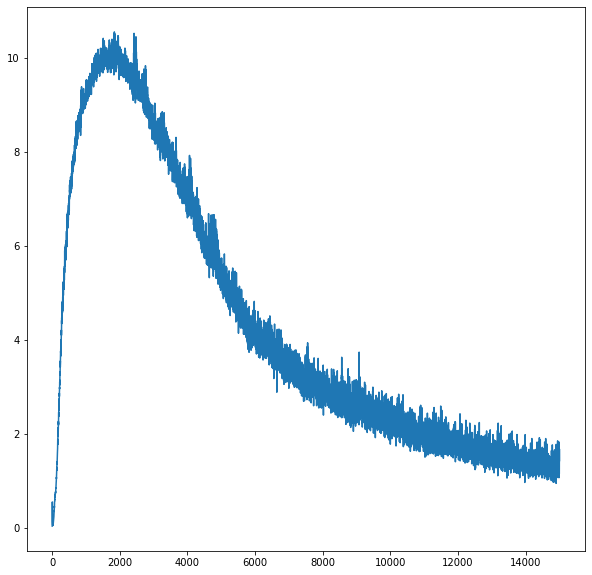

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

# Plot learned gradient field

In [7]:
import numpy as np

X = np.linspace(-4, 4, 30)
Y = np.linspace(-4, 4, 30)
n_sigma = sigmas.size(0)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device).expand(n_sigma, -1, -1)
grad_field = score_net(grid_tensor, sigmas)
grad_field_np = grad_field.detach().cpu().numpy()

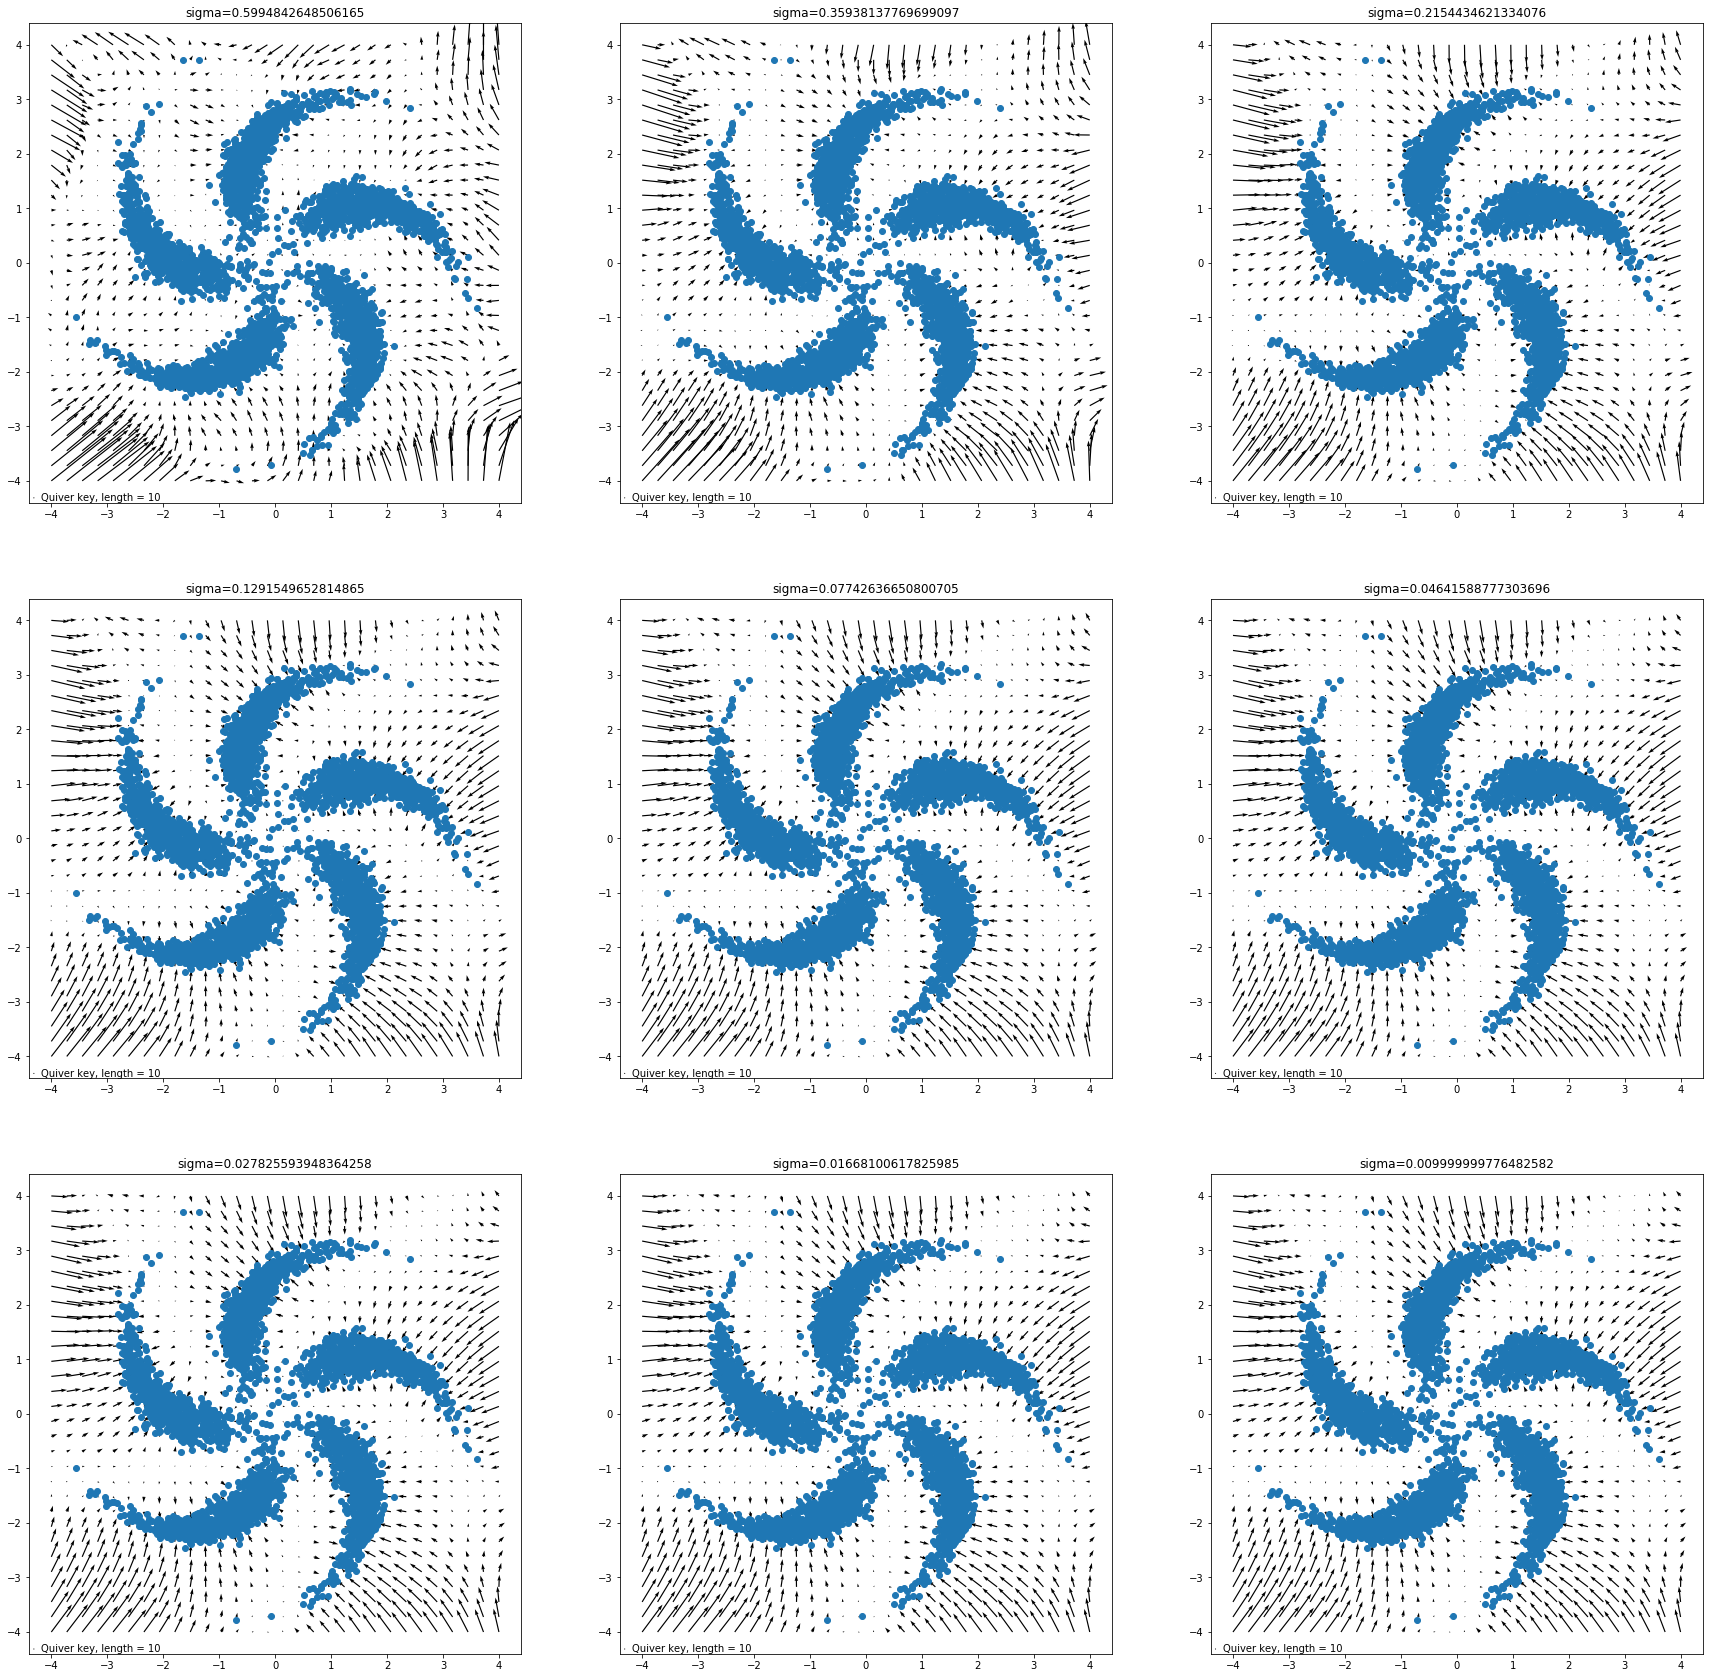

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
sample_data = toy_data.inf_train_gen('pinwheel', n_points=4096)
for i in range(n_sigma):
    q = ax[i // 3, i % 3].quiver(grid[..., 0], grid[..., 1], grad_field_np[i, :, 0], grad_field_np[i, :, 1])
    ax[i // 3, i % 3].quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
    ax[i // 3, i % 3].scatter(sample_data[:, 0], sample_data[:, 1])
    ax[i // 3, i % 3].set_title("sigma={}".format(sigmas[i].item()))

# Visualize sampling

In [25]:
def get_prior(num_points, inp_dim):
    return (torch.rand(num_points, inp_dim) * 2. - 1.) * 4

def langevin_dynamics(model, sigmas, num_points=2048, dim=2, eps=1*1e-6, num_steps=10):
    with torch.no_grad():
        x_list = []
        model.eval()
        x = get_prior(num_points, dim).unsqueeze(0).cuda()
        x_list.append(x.clone())
        for sigma in sigmas:
            alpha = eps * ((sigma / sigmas[-1]) ** 2)
            for t in range(num_steps):
                z_t = torch.randn_like(x)
                x += torch.sqrt(alpha) * z_t + (alpha / 2.) * model(x, sigma.view(1, -1))
            x_list.append(x.clone())
        return x, x_list
    
# def langevin_dynamics_lsd_test(f, l=1., e=.01, num_points=2048, n_steps=100, anneal=None):
#         x_k = get_prior(num_points, 2).cuda()
#         # sgld
#         if anneal == "lin":
#             lrs = list(reversed(np.linspace(e, l, n_steps)))
#         elif anneal == "log":
#             lrs = np.logspace(np.log10(l), np.log10(e))
#         else:
#             lrs = [l for _ in range(n_steps)]
#         x_k_list = [x_k.clone()]
#         for this_lr in lrs:
#             x_k += this_lr * f(x_k) + torch.randn_like(x_k) * e
#             x_k_list.append(x_k.clone())
#         final_samples = x_k.detach()
#         return final_samples, x_k_list

In [26]:
x_final, all_samples = langevin_dynamics(score_net, sigmas, num_steps=10)
all_samples = [item.detach().cpu().numpy() for item in all_samples]

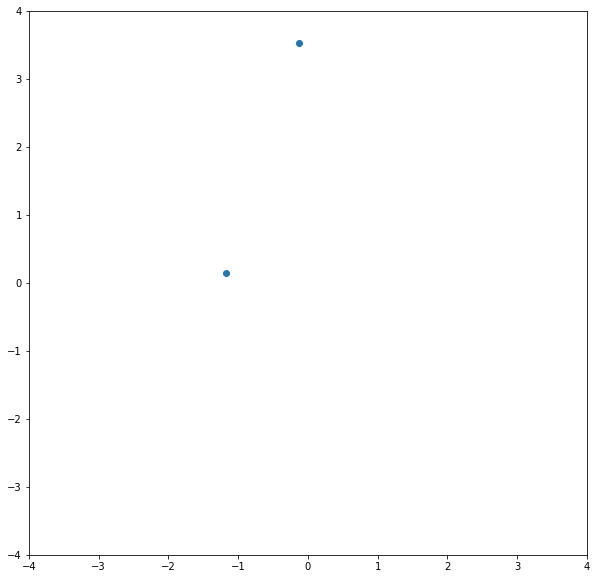

In [24]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)
ax1.scatter(all_samples[-1][:, 0], all_samples[-1][:, 1])

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')

def animate(i, data, scat):
    pts = data[i]
    scatter.set_offsets(pts)
    return scatter,

fig = plt.figure(figsize=(10, 10))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
initial_pts = all_samples[0]
scatter = plt.scatter(initial_pts[:, 0], initial_pts[:, 1])
anim = animation.FuncAnimation(fig, animate, frames=range(len(all_samples) - 1),
                                  fargs=(all_samples, scatter), interval=200)
anim